In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import wilcoxon, kruskal, alexandergovern, mannwhitneyu
from statsmodels.stats.contingency_tables import mcnemar

# Utils

In [60]:
def map_time(df):
    empty_df = pd.DataFrame()
    new_df = pd.concat([empty_df, df[[col for col in df.columns if 'Tempo' in col and col != '20. Paura (Temporali)']]], axis=1)
    new_df['Tempo alla TV'] = df[['Tempo alla TV']].applymap(lambda x: 1 if x == '- di 1 ora al giorno' else 2 if x == 'Da 1 a 2 ore' else 3 if x == '+ di 2 ore' else 0).astype('int')
    new_df['Tempo sui Videogames'] = df[['Tempo sui Videogames']].applymap(lambda x: 1 if x == '- di 1 ora al giorno' else 2 if x == 'Da 1 a 2 ore' else 3 if x == '+di 2 ore' else 0).astype('int')
    new_df['Tempo sui Videogames Elettronici'] = df[['Tempo sui Videogames Elettronici']].applymap(lambda x: 1 if x == '- di 1ora al giorno' else 2 if x == 'Da1 a 2 ore' else 3 if x == '+di 2 ore' else 0).astype('int')
    new_df['Tempo sui social-network'] = df[['Tempo sui social-network']].applymap(lambda x: 1 if x == '- di 1ora al giorno' else 2 if x == 'Da 1 a 2 ore al giorno' else 3 if x == '+di 2 ore al giorno' else 0).astype('int')
    return new_df

In [61]:
def map_civil(df):
    empty_df = pd.DataFrame()
    new_df = pd.concat([empty_df, df[[col for col in df.columns if 'Senso Civile' in col and col != 'Senso Civile (Altro)']]], axis=1)
    new_df = new_df.map(lambda x: 0 if x == 'Indifferente' else 1 if 'Poco' in x else 2).astype('int')
    return new_df

In [62]:
def map_fear(df):
    empty_df = pd.DataFrame()
    new_df = pd.concat([empty_df, df[[col for col in df.columns if 'Paura' in col and col != 'Paura (Altro)']]], axis=1)
    return new_df

In [63]:
def map_fear_retest(df):
    return map_fear(df).map(lambda x: 0 if x == 'Nessuna' else 1 if x == 'Poca' else 2 if x == 'Tanta' else 3).astype('int')

In [64]:
def map_sum(df):
    new_df = pd.DataFrame(df.sum(), columns=['sum']).reset_index()
    new_df.columns = ['item', 'sum']
    return new_df

In [65]:
def frequency_analysis(test, retest):
    results = pd.DataFrame()
    columns = np.unique(np.append(test.columns, retest.columns))
    for col in columns:
        test_freq = test[col].value_counts().to_dict()
        retest_freq = retest[col].value_counts().to_dict()
        difference = {k: retest_freq.get(k, 0) - test_freq.get(k, 0) for k in set(test_freq) | set(retest_freq)}
        temp_df = pd.DataFrame({
            'Variable': [col],
            'Frequency Test': [test_freq],
            'Frequency Retest': [retest_freq],
            'Difference': [difference]
        })
        results = pd.concat([results, temp_df], ignore_index=True)
    return results

In [66]:
def mcnemar_test(test, retest):
    results = pd.DataFrame()
    columns = np.unique(np.append(test.columns, retest.columns))
    for col in columns:
        crosstable = pd.crosstab(test[col], retest[col])
        test_result = mcnemar(crosstable, exact=False, correction=True)
        temp_df = pd.DataFrame({
            'Variable': [col],
            'McNemar Stat': [test_result.statistic],
            'McNemar p-value': [test_result.pvalue]
        })
        results = pd.concat([results, temp_df], ignore_index=True)
    return results

In [67]:
def test_alexandergovern(test, retest):
    results = pd.DataFrame()
    columns = np.unique(np.append(test.columns, retest.columns))
    for col in columns:
        test_result = alexandergovern(test[col], retest[col])
        temp_df = pd.DataFrame({
            'Variable': [col],
            'Alexander Govern Stat': [test_result.statistic],
            'Alexander Govern p-value': [test_result.pvalue]
        })
        results = pd.concat([results, temp_df], ignore_index=True)
    return results

In [68]:
def rank_anova(test, retest):
    results = pd.DataFrame()
    columns = np.unique(np.append(test.columns, retest.columns))
    for col in columns:
        test_result = kruskal(test[col], retest[col])
        temp_df = pd.DataFrame({
            'Variable': [col],
            'Kruskal Stat': [test_result.statistic],
            'Kruskal p-value': [test_result.pvalue]
        })
        results = pd.concat([results, temp_df], ignore_index=True)
    return results

In [69]:
def wilcoxon_rank_test(df1, df2):
    results = pd.DataFrame()
    columns = np.unique(np.append(df1.columns, df2.columns))
    for col in columns:
        stat, p = wilcoxon(df1[col], df2[col], correction=True, alternative='greater')
        temp_df = pd.DataFrame({
            'Variable': [col],
            'Statistic': [stat],
            'p-value': [p]
        })
        results = pd.concat([results, temp_df], ignore_index=True)
    return results
        

In [70]:
def mannwhitneyu_test(test, retest, alternative='greater'):
    results = pd.DataFrame()
    columns = np.unique(np.append(test.columns, retest.columns))
    for col in columns:
        stat, p = mannwhitneyu(test[col], retest[col], alternative=alternative)
        temp_df = pd.DataFrame({
            'Variable': [col],
            'Statistic': [stat],
            'p-value': [p]
        })
        results = pd.concat([results, temp_df], ignore_index=True)
    return results

# Data Cleaning

In [71]:
df = pd.read_csv('./doc/test.csv', sep=';')

# General
df.rename(columns={'Informazioni cronologiche': 'TIME_INFO'}, inplace=True)
df.rename(columns={'1.Da quale scuola provieni': 'SCUOLA'}, inplace=True)
df.rename(columns={'2.Quale classe frequenti': 'CLASSE'}, inplace=True)
df.rename(columns={'3.Età': 'ETA'}, inplace=True)
df.rename(columns={'4.Genere': 'GENERE'}, inplace=True)
df.rename(columns={'5.Nazionalità': 'NAZIONALITA'}, inplace=True)

df['TIME_INFO'].astype('category')
df['SCUOLA'].astype('category')
df['CLASSE'].astype('category')
df['ETA'].astype('int')
df['GENERE'].astype('int')
df['NAZIONALITA'].astype('category')

# Fear
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n1. Essere puniti ': '1. Paura (Essere puniti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n 2. Fare una brutta figura  ': '2. Paura (Fare una brutta figura)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n3. Andare in ospedale    ': '3. Paura (Andare in ospedale)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n4. Perdere una persona cara': '4. Paura (Perdere una persona cara)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n5. Ammalarsi ': '5. Paura (Ammalarsi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n6. Incontrare estranei': '6. Paura (Incontrare estranei)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n7. Guerra': '7. Paura (Guerra)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n8. fare un prelievo/tampone/puntura': '8. Paura (fare un prelievo/tampone/puntura)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n9. Cadere da Luoghi alti': '9. Paura (Cadere da Luoghi alti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n10. Essere presi in giro': '10. Paura (Essere presi in giro)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n11. Serpenti': '11. Paura (Serpenti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n12. Ladri': '12. Paura (Ladri)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n13. Essere interrogati ': '13. Paura (Essere interrogati )'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n14. Allagamenti': '14. Paura (Allagamenti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n15. Ricevere voti bassi': '15. Paura (Ricevere voti bassi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n16. Essere rimproverati': '16. Paura (Essere rimproverati)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n17. Bruciarsi': '17. Paura (Bruciarsi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n18. Tagliarsi o ferirsi': '18. Paura (Tagliarsi o ferirsi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n19. Essere in un luogo affollato': '19. Paura (Essere in un luogo affollato)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n20. Temporali': '20. Paura (Temporali)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n21. Essere investiti da una macchina o da un camion': '21. Paura (Essere investiti da una macchina o da un camion)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n22. Dover andare a scuola': '22. Paura (Dover andare a scuola)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n23. Fare giochi violenti': '23. Paura (Fare giochi violenti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n24. Ucraina': '24. Paura (Ucraina)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n25. Buio': '25. Paura (Buio)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n26. Essere criticati': '26. Paura (Essere criticati)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n27. Il sangue ': '27. Paura (Il sangue)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n28. Trattenersi a scuola dopo l’orario scolastico': '28. Paura (Trattenersi a scuola dopo l\'orario scolastico)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n29. Russia': '29. Paura (Russia)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n30. Pandemia': '30. Paura (Pandemia)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n31. Sbagliare': '31. Paura (Sbagliare)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n32. DAD': '32. Paura (DAD)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n33. Videogames violenti': '33. Paura (Videogames violenti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n34. Film horror': '34. Paura (Film horror)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n35. Sirene di ambulanza e/o polizia': '35. Paura (Sirene di ambulanza e/o polizia)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n36. Terremoti': '36. Paura (Terremoti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n37. Covid 19': '37. Paura (Covid 19)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n38. Spazi chiusi': '38. Paura (Spazi chiusi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n39. Terroristi': '39. Paura (Terroristi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n40. Non riuscire a respirare/soffocare': '40. Paura (Non riuscire a respirare/soffocare)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n41. Affogare': '41. Paura (Affogare)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n42. Rimanere da soli': '42. Paura (Rimanere da soli)'}, inplace=True)
df.rename(columns={'43. Atro (Specificare)': 'Paura (Altro)'}, inplace=True)

# Behaviors
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare.\n\n1. Gettare le carte per strada                                               ': 'Senso Civile (Gettare le carte per strada)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare.\n\n2. Lasciare i rifiuti dove capita                               ': 'Senso Civile (Lasciare i rifiuti dove capita)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n3. Gettare mozziconi di sigarette a terra            ': 'Senso Civile (Gettare mozziconi di sigarette a terra)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n4. Imbrattare i muri ed i mezzi pubblici (treni,pullman)                    ': 'Senso Civile (Imbrattare i muri ed i mezzi pubblici (treni,pullman))'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n5. Non fare la raccolta differenziata            ': 'Senso Civile (Non fare la raccolta differenziata)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n 6. Calpestare i fiori': 'Senso Civile (Calpestare i fiori)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n7. Accendere fuochi nei boschi ': 'Senso Civile (Accendere fuochi nei boschi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare.\n\n8. Parcheggiare dove è vietato': 'Senso Civile (Parcheggiare dove è vietato)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare    \n\n9. Viaggiare senza biglietto                                 ': 'Senso Civile (Viaggiare senza biglietto)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n10. Attraversare con il semaforo rosso              ': 'Senso Civile (Attraversare con il semaforo rosso)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n11. Attraversare la strada fuori dalle strisce pedonali             ': 'Senso Civile (Attraversare la strada fuori dalle strisce pedonali)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare \n\n12. Non allacciare le cinture di sicurezza               ': 'Senso Civile (Non allacciare le cinture di sicurezza)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n13. Non indossare il casco              ': 'Senso Civile (Non indossare il casco)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n14. Maltrattare gli animali                 ': 'Senso Civile (Maltrattare gli animali)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n15. Non lavare le mani    ': 'Senso Civile (Non lavare le mani)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n16. Usare il cellulare a scuola': 'Senso Civile (Usare il cellulare a scuola)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n17. Usare il cellulare a pranzo o cena ': 'Senso Civile (Usare il cellulare a pranzo o cena)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n18. Dire le parolacce    ': 'Senso Civile (Dire le parolacce)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n19. Prendere in giro i propri compagni/e           ': 'Senso Civile (Prendere in giro i propri compagni/e)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n20. Spintonare i propri compagni/e ': 'Senso Civile (Spintonare i propri compagni/e)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n21. Non aiutare i compagni/e e le altre persone in difficoltà ': 'Senso Civile (Non aiutare i compagni/e e le altre persone in difficoltà)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n22. Danneggiare gli oggetti altrui': 'Senso Civile (Danneggiare gli oggetti altrui)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n23. Imbrogliare nel gioco ': 'Senso Civile (Imbrogliare nel gioco)'}, inplace=True)
df.rename(columns={'24. Altro (Specificare)': 'Senso Civile (Altro)'}, inplace=True)

# Mass Media
df.rename(columns={'1. Possiedi un cellulare?': 'POSSIEDI_CELLULARE'}, inplace=True)
df.rename(columns={'2. Utilizzi un cellulare?': 'USI_CELLULARE'}, inplace=True)
df.rename(columns={'3. Che uso ne fai?  ': 'USO_CELLULARE'}, inplace=True)
df.rename(columns={'4. Quali giochi fai con il cellulare?': 'VIDEOGAMES_CELLULARE'}, inplace=True)
df.rename(columns={'1. Quanto tempo guardi la TV?                                ': 'Tempo alla TV'}, inplace=True)
df.rename(columns={'2. Quali programmi preferisci?                                ': 'PROGRAMMI_TV'}, inplace=True)
df.rename(columns={'1. Giochi ai Videogames?': 'VIDEOGAMES'}, inplace=True)
df.rename(columns={'2.Quanto tempo giochi ai videogames?          ': 'Tempo sui Videogames'}, inplace=True)
df.rename(columns={'1.Hai playstation o giochi elettronici ( Wii, XBox, Nintendo Swich)?                                ': 'VIDEOGAMES_ELETTRONICI'}, inplace=True)
df.rename(columns={'3. Quanto tempo giochi?                               ': 'Tempo sui Videogames Elettronici'}, inplace=True)
df.rename(columns={'2. Di che genere?                            ': 'GENERE_VIDEOGAMES_ELETTRONICI'}, inplace=True)
df.rename(columns={'1. Frequenti gruppi social?': 'SOCIAL'}, inplace=True)
df.rename(columns={'2. Quali?                                                    ': 'SOCIAL_PLATFORM'}, inplace=True)
df.rename(columns={'3. Per quanto tempo sei connesso?': 'Tempo sui social-network'}, inplace=True)
df.rename(columns={'4.Segui delle/degli influencer?                                                                             ': 'FOLLOW_INFLUENCERS'}, inplace=True)
df.rename(columns={'1. Secondo te le informazioni su internet sono                                            ': 'INFORMAZIONI_INTERNET'}, inplace=True)
df.rename(columns={'2. Secondo te le informazioni TV sono                                                     ': 'INFORMAZIONI_TV'}, inplace=True)

empty_df = pd.DataFrame()

# Time DF
test_time_df_experimental = map_time(df[(df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D')])
test_time_df_experimental_m = map_time(df[(df['GENERE'] == 1) & ((df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D'))])
test_time_df_experimental_f = map_time(df[(df['GENERE'] == 0) & ((df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D'))])
test_time_df_experimental_sum = map_sum(test_time_df_experimental)
test_time_df_experimental_m_sum = map_sum(test_time_df_experimental_m)
test_time_df_experimental_f_sum = map_sum(test_time_df_experimental_f)

test_time_df_control = map_time(df[(df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_time_df_control_m = map_time(df[(df['GENERE'] == 1) & (df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_time_df_control_f = map_time(df[(df['GENERE'] == 0) & (df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_time_df_control_sum = map_sum(test_time_df_control)
test_time_df_control_m_sum = map_sum(test_time_df_control_m)
test_time_df_control_f_sum = map_sum(test_time_df_control_f)

# Civil DF
test_civil_df_experimental = map_civil(df[(df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D')])
test_civil_df_experimental_m = map_civil(df[(df['GENERE'] == 1) & ((df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D'))])
test_civil_df_experimental_f = map_civil(df[(df['GENERE'] == 0) & ((df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D'))])
test_civil_df_experimental_sum = map_sum(test_civil_df_experimental)
test_civil_df_experimental_m_sum = map_sum(test_civil_df_experimental_m)
test_civil_df_experimental_f_sum = map_sum(test_civil_df_experimental_f)

test_civil_df_control = map_civil(df[(df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_civil_df_control_m = map_civil(df[(df['GENERE'] == 1) & (df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_civil_df_control_f = map_civil(df[(df['GENERE'] == 0) & (df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_civil_df_control_sum = map_sum(test_civil_df_control)
test_civil_df_control_m_sum = map_sum(test_civil_df_control_m)
test_civil_df_control_f_sum = map_sum(test_civil_df_control_f)

# Fear DF
test_fear_df_experimental = map_fear(df[(df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D')])
test_fear_df_experimental_m = map_fear(df[(df['GENERE'] == 1) & ((df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D'))])
test_fear_df_experimental_f = map_fear(df[(df['GENERE'] == 0) & ((df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D'))])
test_fear_df_experimental_sum = map_sum(test_fear_df_experimental)
test_fear_df_experimental_m_sum = map_sum(test_fear_df_experimental_m)
test_fear_df_experimental_f_sum = map_sum(test_fear_df_experimental_f)

test_fear_df_control = map_fear(df[(df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_fear_df_control_m = map_fear(df[(df['GENERE'] == 1) & (df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_fear_df_control_f = map_fear(df[(df['GENERE'] == 0) & (df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_fear_df_control_sum = map_sum(test_fear_df_control)
test_fear_df_control_m_sum = map_sum(test_fear_df_control_m)
test_fear_df_control_f_sum = map_sum(test_fear_df_control_f)


C:\Users\coral\AppData\Local\Temp\ipykernel_18728\3879821305.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df['Tempo alla TV'] = df[['Tempo alla TV']].applymap(lambda x: 1 if x == '- di 1 ora al giorno' else 2 if x == 'Da 1 a 2 ore' else 3 if x == '+ di 2 ore' else 0).astype('int')
C:\Users\coral\AppData\Local\Temp\ipykernel_18728\3879821305.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df['Tempo sui Videogames'] = df[['Tempo sui Videogames']].applymap(lambda x: 1 if x == '- di 1 ora al giorno' else 2 if x == 'Da 1 a 2 ore' else 3 if x == '+di 2 ore' else 0).astype('int')
C:\Users\coral\AppData\Local\Temp\ipykernel_18728\3879821305.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df['Tempo sui Videogames Elettronici'] = df[['Tempo sui Videogames Elettronici']].applymap(lambda x: 1 if x == '- di 1ora al giorno' else 2 if x == 'Da1 a 2 ore' else 3 i

In [72]:
df2 = pd.read_csv('./doc/retest.csv', sep=';', encoding='ISO-8859-1')

# General
df2.rename(columns={'Informazioni cronologiche': 'TIME_INFO'}, inplace=True)
df2.rename(columns={'1.Da quale scuola provieni': 'SCUOLA'}, inplace=True)
df2.rename(columns={'2.Quale classe frequenti': 'CLASSE'}, inplace=True)
df2.rename(columns={'3.Età': 'ETA'}, inplace=True)
df2.rename(columns={'4.Genere': 'GENERE'}, inplace=True)
df2.rename(columns={'5.Nazionalità': 'NAZIONALITA'}, inplace=True)

df2['TIME_INFO'].astype('category')
df2['SCUOLA'].astype('category')
df2['CLASSE'].astype('category')
df2['ETA'].astype('int')
df2['GENERE'] = df2['GENERE'].map(lambda x: 0 if x == 'Femminile' else 1).astype('int')
df2['NAZIONALITA'].astype('category')

# Fear
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n1. Essere puniti ': '1. Paura (Essere puniti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n 2. Fare una brutta figura  ': '2. Paura (Fare una brutta figura)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n3. Andare in ospedale    ': '3. Paura (Andare in ospedale)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n4. Perdere una persona cara': '4. Paura (Perdere una persona cara)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n5. Ammalarsi ': '5. Paura (Ammalarsi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n6. Incontrare estranei': '6. Paura (Incontrare estranei)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n7. Guerra': '7. Paura (Guerra)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n8. fare un prelievo/tampone/puntura': '8. Paura (fare un prelievo/tampone/puntura)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n9. Cadere da Luoghi alti': '9. Paura (Cadere da Luoghi alti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n10. Essere presi in giro': '10. Paura (Essere presi in giro)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n11. Serpenti': '11. Paura (Serpenti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n12. Ladri': '12. Paura (Ladri)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n13. Essere interrogati ': '13. Paura (Essere interrogati )'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n14. Allagamenti': '14. Paura (Allagamenti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n15. Ricevere voti bassi': '15. Paura (Ricevere voti bassi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n16. Essere rimproverati': '16. Paura (Essere rimproverati)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n17. Bruciarsi': '17. Paura (Bruciarsi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n18. Tagliarsi o ferirsi': '18. Paura (Tagliarsi o ferirsi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n19. Essere in un luogo affollato': '19. Paura (Essere in un luogo affollato)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n20. Temporali': '20. Paura (Temporali)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n21. Essere investiti da una macchina o da un camion': '21. Paura (Essere investiti da una macchina o da un camion)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n22. Dover andare a scuola': '22. Paura (Dover andare a scuola)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n23. Fare giochi violenti': '23. Paura (Fare giochi violenti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n24. Ucraina': '24. Paura (Ucraina)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n25. Buio': '25. Paura (Buio)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n26. Essere criticati': '26. Paura (Essere criticati)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n27. Il sangue ': '27. Paura (Il sangue)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n28. Trattenersi a scuola dopo lorario scolastico': '28. Paura (Trattenersi a scuola dopo l\'orario scolastico)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n29. Russia': '29. Paura (Russia)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n30. Pandemia': '30. Paura (Pandemia)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n31. Sbagliare': '31. Paura (Sbagliare)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n32. DAD': '32. Paura (DAD)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n33. Videogames violenti': '33. Paura (Videogames violenti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n34. Film horror': '34. Paura (Film horror)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n35. Sirene di ambulanza e/o polizia': '35. Paura (Sirene di ambulanza e/o polizia)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n36. Terremoti': '36. Paura (Terremoti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n37. Covid 19': '37. Paura (Covid 19)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n38. Spazi chiusi': '38. Paura (Spazi chiusi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n39. Terroristi': '39. Paura (Terroristi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n40. Non riuscire a respirare/soffocare': '40. Paura (Non riuscire a respirare/soffocare)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n41. Affogare': '41. Paura (Affogare)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n42. Rimanere da soli': '42. Paura (Rimanere da soli)'}, inplace=True)
df2.rename(columns={'43. Atro (Specificare)': 'Paura (Altro)'}, inplace=True)

# # Behaviors
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare.\n\n1. Gettare le carte per strada                                               ': 'Senso Civile (Gettare le carte per strada)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare.\n\n2. Lasciare i rifiuti dove capita                               ': 'Senso Civile (Lasciare i rifiuti dove capita)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n3. Gettare mozziconi di sigarette a terra            ': 'Senso Civile (Gettare mozziconi di sigarette a terra)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n4. Imbrattare i muri ed i mezzi pubblici (treni,pullman)                    ': 'Senso Civile (Imbrattare i muri ed i mezzi pubblici (treni,pullman))'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n5. Non fare la raccolta differenziata            ': 'Senso Civile (Non fare la raccolta differenziata)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n 6. Calpestare i fiori': 'Senso Civile (Calpestare i fiori)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n7. Accendere fuochi nei boschi ': 'Senso Civile (Accendere fuochi nei boschi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare.\n\n8. Parcheggiare dove è vietato': 'Senso Civile (Parcheggiare dove è vietato)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare    \n\n9. Viaggiare senza biglietto                                 ': 'Senso Civile (Viaggiare senza biglietto)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n10. Attraversare con il semaforo rosso              ': 'Senso Civile (Attraversare con il semaforo rosso)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n11. Attraversare la strada fuori dalle strisce pedonali             ': 'Senso Civile (Attraversare la strada fuori dalle strisce pedonali)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare \n\n12. Non allacciare le cinture di sicurezza               ': 'Senso Civile (Non allacciare le cinture di sicurezza)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n13. Non indossare il casco              ': 'Senso Civile (Non indossare il casco)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n14. Maltrattare gli animali                 ': 'Senso Civile (Maltrattare gli animali)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n15. Non lavare le mani    ': 'Senso Civile (Non lavare le mani)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n16. Usare il cellulare a scuola': 'Senso Civile (Usare il cellulare a scuola)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n17. Usare il cellulare a pranzo o cena ': 'Senso Civile (Usare il cellulare a pranzo o cena)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n18. Dire le parolacce    ': 'Senso Civile (Dire le parolacce)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n19. Prendere in giro i propri compagni/e           ': 'Senso Civile (Prendere in giro i propri compagni/e)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n20. Spintonare i propri compagni/e ': 'Senso Civile (Spintonare i propri compagni/e)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n21. Non aiutare i compagni/e e le altre persone in difficoltà ': 'Senso Civile (Non aiutare i compagni/e e le altre persone in difficoltà)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n22. Danneggiare gli oggetti altrui': 'Senso Civile (Danneggiare gli oggetti altrui)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n23. Imbrogliare nel gioco ': 'Senso Civile (Imbrogliare nel gioco)'}, inplace=True)
df2.rename(columns={'24. Altro (Specificare)': 'Senso Civile (Altro)'}, inplace=True)

# # Mass Media
df2.rename(columns={'1. Possiedi un cellulare?': 'POSSIEDI_CELLULARE'}, inplace=True)
df2.rename(columns={'2. Utilizzi un cellulare?': 'USI_CELLULARE'}, inplace=True)
df2.rename(columns={'3. Che uso ne fai?  ': 'USO_CELLULARE'}, inplace=True)
df2.rename(columns={'4. Quali giochi fai con il cellulare?': 'VIDEOGAMES_CELLULARE'}, inplace=True)
df2.rename(columns={'1. Quanto tempo guardi la TV?                                ': 'Tempo alla TV'}, inplace=True)
df2.rename(columns={'2. Quali programmi preferisci?                                ': 'PROGRAMMI_TV'}, inplace=True)
df2.rename(columns={'1. Giochi ai Videogames?': 'VIDEOGAMES'}, inplace=True)
df2.rename(columns={'2.Quanto tempo giochi ai videogames?          ': 'Tempo sui Videogames'}, inplace=True)
df2.rename(columns={'1.Hai playstation o giochi elettronici ( Wii, XBox, Nintendo Swich)?                                ': 'VIDEOGAMES_ELETTRONICI'}, inplace=True)
df2.rename(columns={'3. Quanto tempo giochi?                               ': 'Tempo sui Videogames Elettronici'}, inplace=True)
df2.rename(columns={'2. Di che genere?                            ': 'GENERE_VIDEOGAMES_ELETTRONICI'}, inplace=True)
df2.rename(columns={'1. Frequenti gruppi social?': 'SOCIAL'}, inplace=True)
df2.rename(columns={'2. Quali?                                                    ': 'SOCIAL_PLATFORM'}, inplace=True)
df2.rename(columns={'3. Per quanto tempo sei connesso?': 'Tempo sui social-network'}, inplace=True)
df2.rename(columns={'4.Segui delle/degli influencer?                                                                             ': 'FOLLOW_INFLUENCERS'}, inplace=True)
df2.rename(columns={'1. Secondo te le informazioni su internet sono                                            ': 'INFORMAZIONI_INTERNET'}, inplace=True)
df2.rename(columns={'2. Secondo te le informazioni TV sono                                                     ': 'INFORMAZIONI_TV'}, inplace=True)

# Time DF
retest_time_df_experimental = map_time(df2[(df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D')])
retest_time_df_experimental_m = map_time(df2[(df2['GENERE'] == 1) & ((df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D'))])
retest_time_df_experimental_f = map_time(df2[(df2['GENERE'] == 0) & ((df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D'))])
retest_time_df_experimental_sum = map_sum(retest_time_df_experimental)
retest_time_df_experimental_m_sum = map_sum(retest_time_df_experimental_m)
retest_time_df_experimental_f_sum = map_sum(retest_time_df_experimental_f)

retest_time_df_control = map_time(df2[(df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_time_df_control_m = map_time(df2[(df2['GENERE'] == 1) & (df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_time_df_control_f = map_time(df2[(df2['GENERE'] == 0) & (df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_time_df_control_sum = map_sum(retest_time_df_control)
retest_time_df_control_m_sum = map_sum(retest_time_df_control_m)
retest_time_df_control_f_sum = map_sum(retest_time_df_control_f)

# Civil DF
retest_civil_df_experimental = map_civil(df2[(df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D')])
retest_civil_df_experimental_m = map_civil(df2[(df2['GENERE'] == 1) & ((df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D'))])
retest_civil_df_experimental_f = map_civil(df2[(df2['GENERE'] == 0) & ((df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D'))])
retest_civil_df_experimental_sum = map_sum(retest_civil_df_experimental)
retest_civil_df_experimental_m_sum = map_sum(retest_civil_df_experimental_m)
retest_civil_df_experimental_f_sum = map_sum(retest_civil_df_experimental_f)

retest_civil_df_control = map_civil(df2[(df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_civil_df_control_m = map_civil(df2[(df2['GENERE'] == 1) & (df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_civil_df_control_f = map_civil(df2[(df2['GENERE'] == 0) & (df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_civil_df_control_sum = map_sum(retest_civil_df_control)
retest_civil_df_control_m_sum = map_sum(retest_civil_df_control_m)
retest_civil_df_control_f_sum = map_sum(retest_civil_df_control_f)

# Fear DF
retest_fear_df_experimental = map_fear_retest(df2[(df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D')])
retest_fear_df_experimental_m = map_fear_retest(df2[(df2['GENERE'] == 1) & ((df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D'))])
retest_fear_df_experimental_f = map_fear_retest(df2[(df2['GENERE'] == 0) & ((df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D'))])
retest_fear_df_experimental_sum = map_sum(retest_fear_df_experimental)
retest_fear_df_experimental_m_sum = map_sum(retest_fear_df_experimental_m)
retest_fear_df_experimental_f_sum = map_sum(retest_fear_df_experimental_f)


retest_fear_df_control = map_fear_retest(df2[(df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_fear_df_control_m = map_fear_retest(df2[(df2['GENERE'] == 1) & (df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_fear_df_control_f = map_fear_retest(df2[(df2['GENERE'] == 0) & (df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_fear_df_control_sum = map_sum(retest_fear_df_control)
retest_fear_df_control_m_sum = map_sum(retest_fear_df_control_m)
retest_fear_df_control_f_sum = map_sum(retest_fear_df_control_f)


C:\Users\coral\AppData\Local\Temp\ipykernel_18728\3879821305.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df['Tempo alla TV'] = df[['Tempo alla TV']].applymap(lambda x: 1 if x == '- di 1 ora al giorno' else 2 if x == 'Da 1 a 2 ore' else 3 if x == '+ di 2 ore' else 0).astype('int')
C:\Users\coral\AppData\Local\Temp\ipykernel_18728\3879821305.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df['Tempo sui Videogames'] = df[['Tempo sui Videogames']].applymap(lambda x: 1 if x == '- di 1 ora al giorno' else 2 if x == 'Da 1 a 2 ore' else 3 if x == '+di 2 ore' else 0).astype('int')
C:\Users\coral\AppData\Local\Temp\ipykernel_18728\3879821305.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df['Tempo sui Videogames Elettronici'] = df[['Tempo sui Videogames Elettronici']].applymap(lambda x: 1 if x == '- di 1ora al giorno' else 2 if x == 'Da1 a 2 ore' else 3 i

# Data Understanding

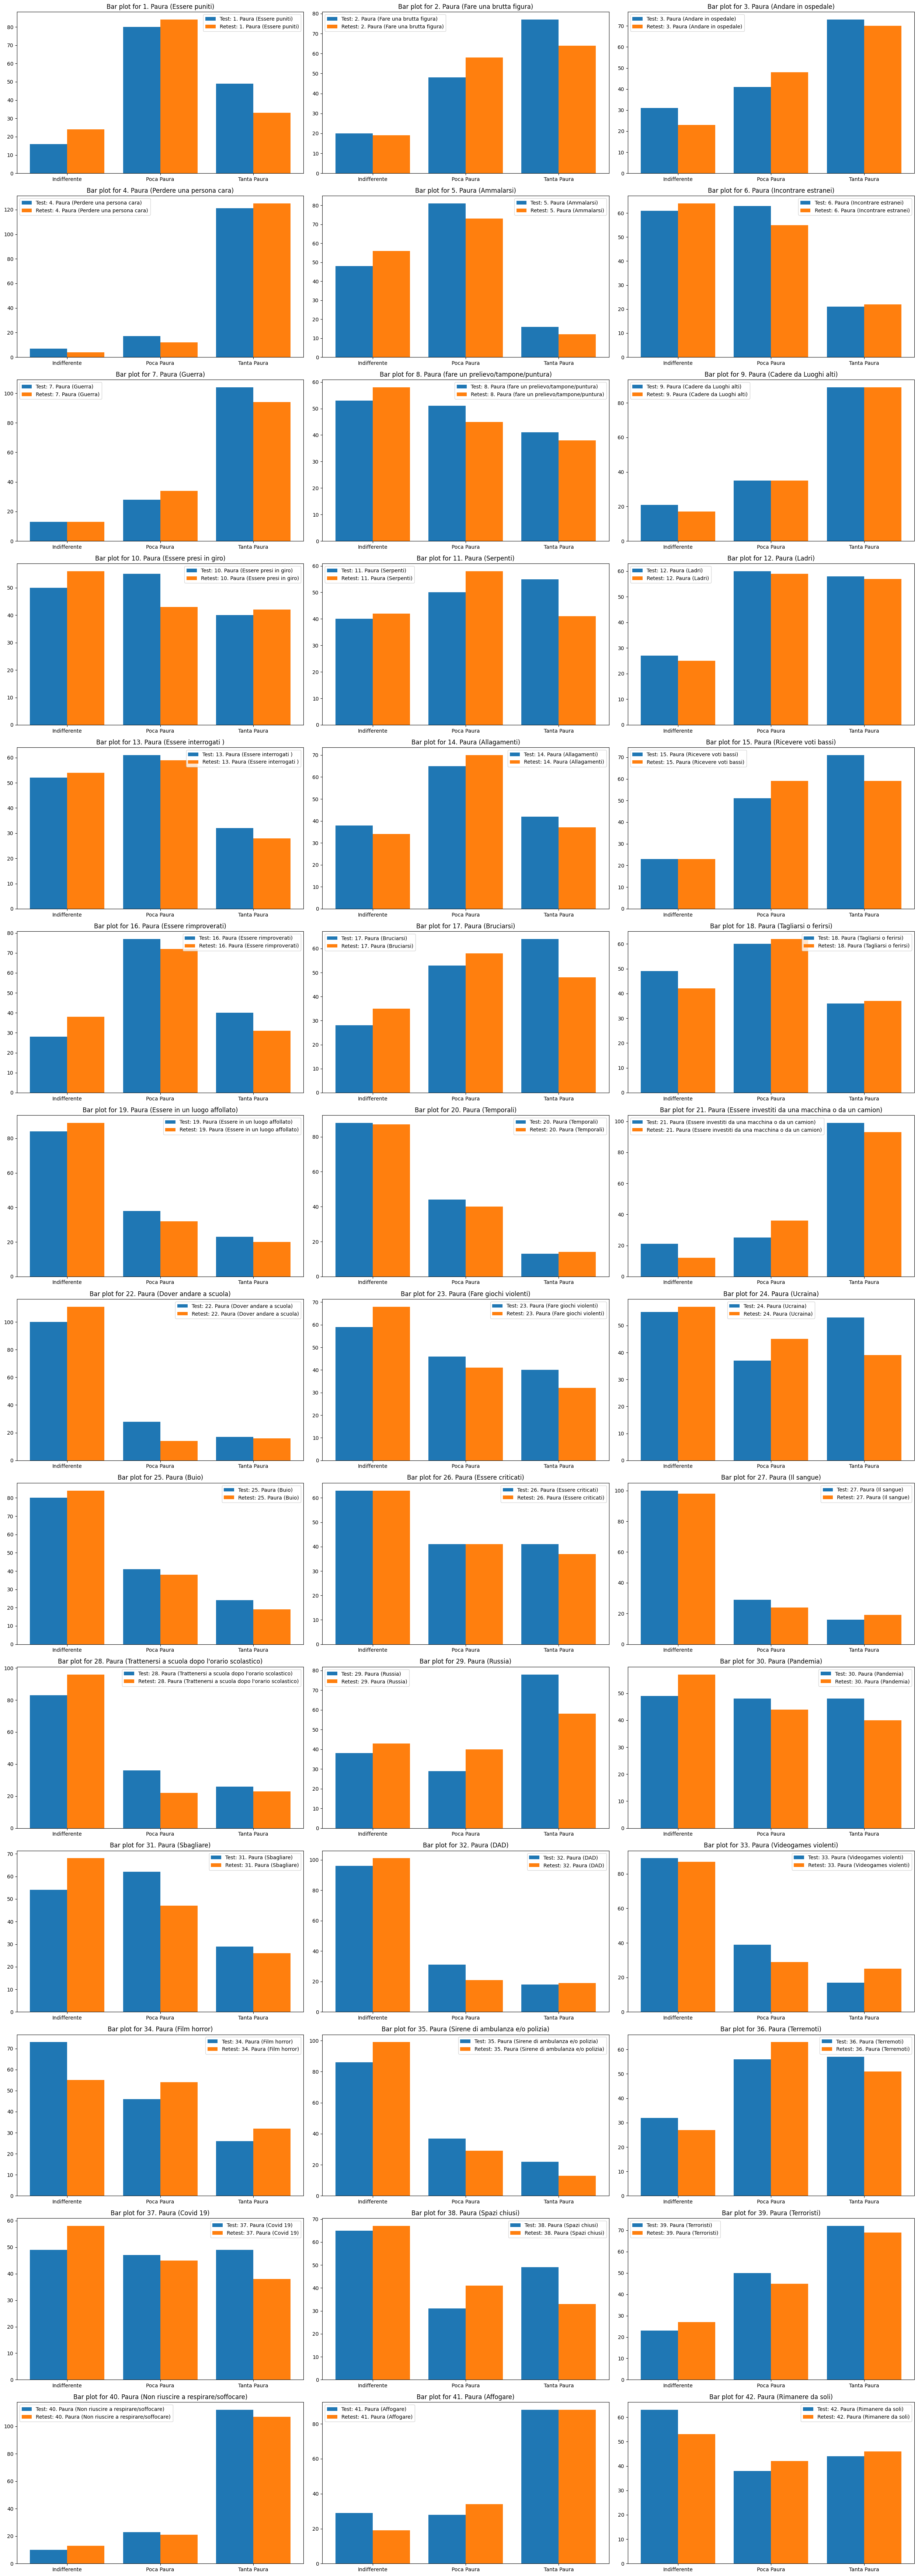

In [73]:
import math

# Calculate the number of rows and columns for the subplots
num_cols = 3
num_rows = math.ceil(len(test_fear_df_experimental.columns) / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, num_rows * 5))  # Create a new figure with subplots

for i, col in enumerate(test_fear_df_experimental.columns):
    ax = axs[i // num_cols, i % num_cols]  # Get the current axes
    values, counts = np.unique(test_fear_df_experimental[col], return_counts=True)
    ax.bar(values - 0.2, counts, width=0.4, label=f'Test: {col}', align='center')
    values, counts = np.unique(retest_fear_df_experimental[col], return_counts=True)
    ax.bar(values + 0.2, counts, width=0.4, label=f'Retest: {col}', align='center')
    ax.set_title(f'Bar plot for {col}')
    ax.legend()  # Add a legend
    ax.set_xticks([0, 1, 2])  # Set the x-ticks to the possible values
    ax.set_xticklabels(['Indifferente', 'Poca Paura', 'Tanta Paura'])  # Set the x-tick labels


plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the figure

# Fear

In [74]:
test_fear_df_experimental = test_fear_df_experimental.sample(n=len(retest_fear_df_experimental.index))

## Frequency Analysis - Experimental

In [75]:
fa_fear_experimental = frequency_analysis(test_fear_df_experimental, retest_fear_df_experimental)
fa_fear_experimental.to_csv('./report-output/fa_fear_experimental.csv', index=False, sep=';')
fa_fear_experimental

Variable          Frequency Test  \
0                            1. Paura (Essere puniti)   {1: 79, 2: 46, 0: 16}   
1                    10. Paura (Essere presi in giro)   {1: 53, 0: 48, 2: 40}   
2                                11. Paura (Serpenti)   {2: 54, 1: 47, 0: 40}   
3                                   12. Paura (Ladri)   {1: 60, 2: 55, 0: 26}   
4                     13. Paura (Essere interrogati )   {1: 59, 0: 51, 2: 31}   
5                             14. Paura (Allagamenti)   {1: 64, 2: 41, 0: 36}   
6                     15. Paura (Ricevere voti bassi)   {2: 67, 1: 51, 0: 23}   
7                     16. Paura (Essere rimproverati)   {1: 75, 2: 38, 0: 28}   
8                               17. Paura (Bruciarsi)   {2: 63, 1: 51, 0: 27}   
9                     18. Paura (Tagliarsi o ferirsi)   {1: 59, 0: 47, 2: 35}   
10           19. Paura (Essere in un luogo affollato)   {0: 81, 1: 37, 2: 23}   
11                  2. Paura (Fare una brutta figura)   {2: 76, 1: 46, 0: 19}   
12                              20. Paura (Temporali)   {0: 86, 1: 42, 2: 13}   
13  21. Paura (Essere investiti da una macchina o ...   {2: 97, 1: 24, 0: 20}   
14                  22. Paura (Dover andare a scuola)   {0: 98, 1: 27, 2: 16}   
15                   23. Paura (Fare giochi violenti)   {0: 57, 1: 46, 2: 38}   
16                                24. Paura (Ucraina)   {0: 54, 2: 51, 1: 36}   
17                                   25. Paura (Buio)   {0: 78, 1: 40, 2: 23}   
18                       26. Paura (Essere criticati)   {0: 61, 2: 41, 1: 39}   
19                              27. Paura (Il sangue)   {0: 98, 1: 28, 2: 15}   
20  28. Paura (Trattenersi a scuola dopo l'orario ...   {0: 80, 1: 36, 2: 25}   
21                                 29. Paura (Russia)   {2: 76, 0: 37, 1: 28}   
22                      3. Paura (Andare in ospedale)   {2: 71, 1: 39, 0: 31}   
23                               30. Paura (Pandemia)   {1: 47, 2: 47, 0: 47}   
24                              31. Paura (Sbagliare)   {1: 59, 0: 54, 2: 28}   
25                                    32. Paura (DAD)   {0: 93, 1: 30, 2: 18}   
26                    33. Paura (Videogames violenti)   {0: 86, 1: 39, 2: 16}   
27                            34. Paura (Film horror)   {0: 73, 1: 45, 2: 23}   
28        35. Paura (Sirene di ambulanza e/o polizia)   {0: 84, 1: 37, 2: 20}   
29                              36. Paura (Terremoti)   {2: 56, 1: 54, 0: 31}   
30                               37. Paura (Covid 19)   {0: 47, 2: 47, 1: 47}   
31                           38. Paura (Spazi chiusi)   {0: 63, 2: 48, 1: 30}   
32                             39. Paura (Terroristi)   {2: 69, 1: 49, 0: 23}   
33                4. Paura (Perdere una persona cara)   {2: 117, 1: 17, 0: 7}   
34     40. Paura (Non riuscire a respirare/soffocare)  {2: 108, 1: 23, 0: 10}   
35                               41. Paura (Affogare)   {2: 85, 1: 28, 0: 28}   
36                       42. Paura (Rimanere da soli)   {0: 62, 2: 42, 1: 37}   
37                               5. Paura (Ammalarsi)   {1: 78, 0: 47, 2: 16}   
38                     6. Paura (Incontrare estranei)   {1: 62, 0: 59, 2: 20}   
39                                  7. Paura (Guerra)  {2: 101, 1: 28, 0: 12}   
40        8. Paura (fare un prelievo/tampone/puntura)   {0: 52, 1: 48, 2: 41}   
41                   9. Paura (Cadere da Luoghi alti)   {2: 87, 1: 33, 0: 21}   

          Frequency Retest              Difference  
0    {1: 84, 2: 33, 0: 24}    {0: 8, 1: 5, 2: -13}  
1    {0: 56, 1: 43, 2: 42}    {0: 8, 1: -10, 2: 2}  
2    {1: 58, 0: 42, 2: 41}   {0: 2, 1: 11, 2: -13}  
3    {1: 59, 2: 57, 0: 25}    {0: -1, 1: -1, 2: 2}  
4    {1: 59, 0: 54, 2: 28}     {0: 3, 1: 0, 2: -3}  
5    {1: 70, 2: 37, 0: 34}    {0: -2, 1: 6, 2: -4}  
6    {1: 59, 2: 59, 0: 23}     {0: 0, 1: 8, 2: -8}  
7    {1: 72, 0: 38, 2: 31}   {0: 10, 1: -3, 2: -7}  
8    {1: 58, 2: 48, 0: 35}    {0: 8, 1: 7, 2: -15}  
9    {1: 62, 0: 42, 2: 37}     

## Frequency Anlysis - Control

In [76]:
fa_fear_control = frequency_analysis(test_fear_df_control, retest_fear_df_control)
fa_fear_control.to_csv('./report-output/fa_fear_control.csv', index=False, sep=';')
fa_fear_control

Variable          Frequency Test  \
0                            1. Paura (Essere puniti)  {1: 131, 2: 41, 0: 33}   
1                    10. Paura (Essere presi in giro)   {1: 90, 2: 59, 0: 56}   
2                                11. Paura (Serpenti)   {0: 85, 2: 64, 1: 56}   
3                                   12. Paura (Ladri)   {2: 93, 1: 77, 0: 35}   
4                     13. Paura (Essere interrogati )   {0: 77, 1: 76, 2: 52}   
5                             14. Paura (Allagamenti)   {1: 86, 2: 63, 0: 56}   
6                     15. Paura (Ricevere voti bassi)   {2: 93, 1: 85, 0: 27}   
7                     16. Paura (Essere rimproverati)  {1: 119, 2: 43, 0: 43}   
8                               17. Paura (Bruciarsi)   {2: 84, 1: 75, 0: 46}   
9                     18. Paura (Tagliarsi o ferirsi)   {1: 90, 0: 74, 2: 41}   
10           19. Paura (Essere in un luogo affollato)  {0: 140, 1: 44, 2: 21}   
11                  2. Paura (Fare una brutta figura)  {2: 105, 1: 74, 0: 26}   
12                              20. Paura (Temporali)  {0: 149, 1: 43, 2: 13}   
13  21. Paura (Essere investiti da una macchina o ...  {2: 150, 1: 41, 0: 14}   
14                  22. Paura (Dover andare a scuola)  {0: 160, 1: 31, 2: 14}   
15                   23. Paura (Fare giochi violenti)   {1: 79, 0: 69, 2: 57}   
16                                24. Paura (Ucraina)   {2: 83, 0: 71, 1: 51}   
17                                   25. Paura (Buio)  {0: 104, 1: 66, 2: 35}   
18                       26. Paura (Essere criticati)   {0: 83, 1: 66, 2: 56}   
19                              27. Paura (Il sangue)  {0: 127, 1: 48, 2: 30}   
20  28. Paura (Trattenersi a scuola dopo l'orario ...  {0: 114, 1: 61, 2: 30}   
21                                 29. Paura (Russia)  {2: 104, 1: 52, 0: 49}   
22                      3. Paura (Andare in ospedale)  {2: 110, 1: 62, 0: 33}   
23                               30. Paura (Pandemia)   {1: 84, 2: 63, 0: 58}   
24                              31. Paura (Sbagliare)   {1: 80, 0: 77, 2: 48}   
25                                    32. Paura (DAD)  {0: 138, 1: 46, 2: 21}   
26                    33. Paura (Videogames violenti)  {0: 133, 1: 44, 2: 28}   
27                            34. Paura (Film horror)   {0: 94, 1: 57, 2: 54}   
28        35. Paura (Sirene di ambulanza e/o polizia)  {0: 123, 1: 62, 2: 20}   
29                              36. Paura (Terremoti)   {1: 90, 2: 79, 0: 36}   
30                               37. Paura (Covid 19)   {1: 75, 0: 66, 2: 64}   
31                           38. Paura (Spazi chiusi)   {0: 93, 1: 58, 2: 54}   
32                             39. Paura (Terroristi)  {2: 113, 1: 59, 0: 33}   
33                4. Paura (Perdere una persona cara)   {2: 184, 1: 19, 0: 2}   
34     40. Paura (Non riuscire a respirare/soffocare)   {2: 174, 1: 26, 0: 5}   
35                               41. Paura (Affogare)  {2: 147, 1: 35, 0: 23}   
36                       42. Paura (Rimanere da soli)   {0: 79, 1: 72, 2: 54}   
37                               5. Paura (Ammalarsi)  {1: 105, 0: 81, 2: 19}   
38                     6. Paura (Incontrare estranei)   {0: 98, 1: 76, 2: 31}   
39                                  7. Paura (Guerra)  {2: 151, 1: 42, 0: 12}   
40        8. Paura (fare un prelievo/tampone/puntura)   {1: 84, 0: 72, 2: 49}   
41                   9. Paura (Cadere da Luoghi alti)  {2: 138, 1: 41, 0: 26}   

          Frequency Retest               Difference  
0   {1: 120, 0: 45, 2: 40}   {0: 12, 1: -11, 2: -1}  
1    {0: 87, 1: 70, 2: 48}  {0: 31, 1: -20, 2: -11}  
2    {0: 92, 2: 60, 1: 53}     {0: 7, 1: -3, 2: -4}  
3    {1: 90, 2: 65, 0: 50}   {0: 15, 1: 13, 2: -28}  
4   {0: 104, 1: 55, 2: 46}   {0: 27, 1: -21, 2: -6}  
5    {1: 77, 0: 72, 2: 56}    {0: 16, 1: -9, 2: -7}  
6    {2: 88, 1: 77, 0: 40}    {0: 13, 1: -8, 2: -5}  
7    {1: 93, 0: 75, 2: 37}   {0: 32, 1: -26, 2: -6}  
8    {1: 90, 0: 65, 2: 50}   {0: 19, 1: 15, 2: -34}  
9    {0: 96, 1: 72, 2

## Alexander Govern - H0: Stessa Media, H1: Media Diversa

In [77]:
alex_fear = test_alexandergovern(test_fear_df_experimental, retest_fear_df_experimental).sort_values(by='Alexander Govern p-value')
alex_fear.to_csv('./report-output/alexander_govern_fear.csv', index=False, sep=';')
alex_fear

Variable  Alexander Govern Stat  \
27                            34. Paura (Film horror)               4.430080   
0                            1. Paura (Essere puniti)               3.867246   
28        35. Paura (Sirene di ambulanza e/o polizia)               3.537545   
8                               17. Paura (Bruciarsi)               3.200183   
21                                 29. Paura (Russia)               2.812311   
7                     16. Paura (Essere rimproverati)               2.126565   
30                               37. Paura (Covid 19)               2.106483   
20  28. Paura (Trattenersi a scuola dopo l'orario ...               1.938936   
33                4. Paura (Perdere una persona cara)               1.883156   
31                           38. Paura (Spazi chiusi)               1.769446   
24                              31. Paura (Sbagliare)               1.591458   
15                   23. Paura (Fare giochi violenti)               1.555984   
37                               5. Paura (Ammalarsi)               1.509692   
23                               30. Paura (Pandemia)               1.509154   
14                  22. Paura (Dover andare a scuola)               1.290104   
2                                11. Paura (Serpenti)               1.264800   
16                                24. Paura (Ucraina)               1.118419   
11                  2. Paura (Fare una brutta figura)               1.011488   
35                               41. Paura (Affogare)               0.871641   
36                       42. Paura (Rimanere da soli)               0.835536   
10           19. Paura (Essere in un luogo affollato)               0.769415   
17                                   25. Paura (Buio)               0.647666   
39                                  7. Paura (Guerra)               0.539329   
40        8. Paura (fare un prelievo/tampone/puntura)               0.432135   
6                     15. Paura (Ricevere voti bassi)               0.424418   
26                    33. Paura (Videogames violenti)               0.416300   
25                                    32. Paura (DAD)               0.337821   
9                     18. Paura (Tagliarsi o ferirsi)               0.303206   
22                      3. Paura (Andare in ospedale)               0.288440   
41                   9. Paura (Cadere da Luoghi alti)               0.243280   
4                     13. Paura (Essere interrogati )               0.227684   
1                    10. Paura (Essere presi in giro)               0.193341   
18                       26. Paura (Essere criticati)               0.183186   
34     40. Paura (Non riuscire a respirare/soffocare)               0.147600   
13  21. Paura (Essere investiti da una macchina o ...               0.118623   
19                              27. Paura (Il sangue)               0.115624   
32                             39. Paura (Terroristi)               0.098622   
38                     6. Paura (Incontrare estranei)               0.062831   
3                                   12. Paura (Ladri)               0.059446   
5                             14. Paura (Allagamenti)               0.026782   
29                              36. Paura (Terremoti)               0.006322   
12                              20. Paura (Temporali)               0.000000   

    Alexander Govern p-value  
27                  0.035311  
0                   0.049237  
28                  0.059994  
8                   0.073630  
21                  0.093544  
7                   0.144765  
30                  0.146676  
20                  0.163784  
33                  0.169976  
31                  0.183451  
24                  0.207118  
15                  0.212254  
37                  0.219186  
23                  0.219268  
14                  0.256029  
2                   0.260745  
16                  0.290259  
11                  0.314547  
35             

## Mannwhitneyu - H0: Stessa distribuzione, H1: Distribuzione Diversa

In [78]:
mann_fear = mannwhitneyu_test(test_fear_df_experimental, retest_fear_df_experimental).sort_values(by='p-value')
mann_fear.to_csv('./report-output/mannwhitneyu_fear.csv', index=False, sep=';')
mann_fear

Variable  Statistic   p-value
0                            1. Paura (Essere puniti)    11133.0  0.024505
28        35. Paura (Sirene di ambulanza e/o polizia)    11047.5  0.027767
8                               17. Paura (Bruciarsi)    11107.5  0.033944
21                                 29. Paura (Russia)    11071.5  0.037161
20  28. Paura (Trattenersi a scuola dopo l'orario ...    10929.5  0.047018
14                  22. Paura (Dover andare a scuola)    10753.0  0.061054
7                     16. Paura (Essere rimproverati)    10851.0  0.072425
30                               37. Paura (Covid 19)    10880.5  0.072498
24                              31. Paura (Sbagliare)    10818.5  0.083367
15                   23. Paura (Fare giochi violenti)    10759.0  0.099912
23                               30. Paura (Pandemia)    10739.5  0.107806
37                               5. Paura (Ammalarsi)    10691.0  0.109897
31                           38. Paura (Spazi chiusi)    10711.5  0.112811
11                  2. Paura (Fare una brutta figura)    10672.5  0.119772
2                                11. Paura (Serpenti)    10684.0  0.124441
16                                24. Paura (Ucraina)    10597.5  0.153766
10           19. Paura (Essere in un luogo affollato)    10502.5  0.173879
39                                  7. Paura (Guerra)    10412.0  0.198232
25                                    32. Paura (DAD)    10408.5  0.201451
17                                   25. Paura (Buio)    10420.5  0.214796
6                     15. Paura (Ricevere voti bassi)    10412.5  0.227185
40        8. Paura (fare un prelievo/tampone/puntura)    10374.0  0.250465
1                    10. Paura (Essere presi in giro)    10251.5  0.314973
4                     13. Paura (Essere interrogati )    10240.5  0.319167
18                       26. Paura (Essere criticati)    10200.5  0.342344
38                     6. Paura (Incontrare estranei)    10161.0  0.363140
32                             39. Paura (Terroristi)    10084.5  0.409578
34     40. Paura (Non riuscire a respirare/soffocare)    10055.5  0.411003
5                             14. Paura (Allagamenti)    10050.5  0.431397
29                              36. Paura (Terremoti)    10045.5  0.434839
13  21. Paura (Essere investiti da una macchina o ...    10006.5  0.453929
12                              20. Paura (Temporali)     9977.0  0.475693
19                              27. Paura (Il sangue)     9854.5  0.561961
3                                   12. Paura (Ladri)     9782.5  0.598763
26                    33. Paura (Videogames violenti)     9755.5  0.622630
22                      3. Paura (Andare in ospedale)     9715.5  0.640433
41                   9. Paura (Cadere da Luoghi alti)     9712.5  0.650922
9                     18. Paura (Tagliarsi o ferirsi)     9581.5  0.712920
35                               41. Paura (Affogare)     9519.0  0.761089
36                       42. Paura (Rimanere da soli)     9337.0  0.826497
33                4. Paura (Perdere una persona cara)     9368.5  0.916261
27                            34. Paura (Film horror)     8572.5  0.984629

## Data Understanding

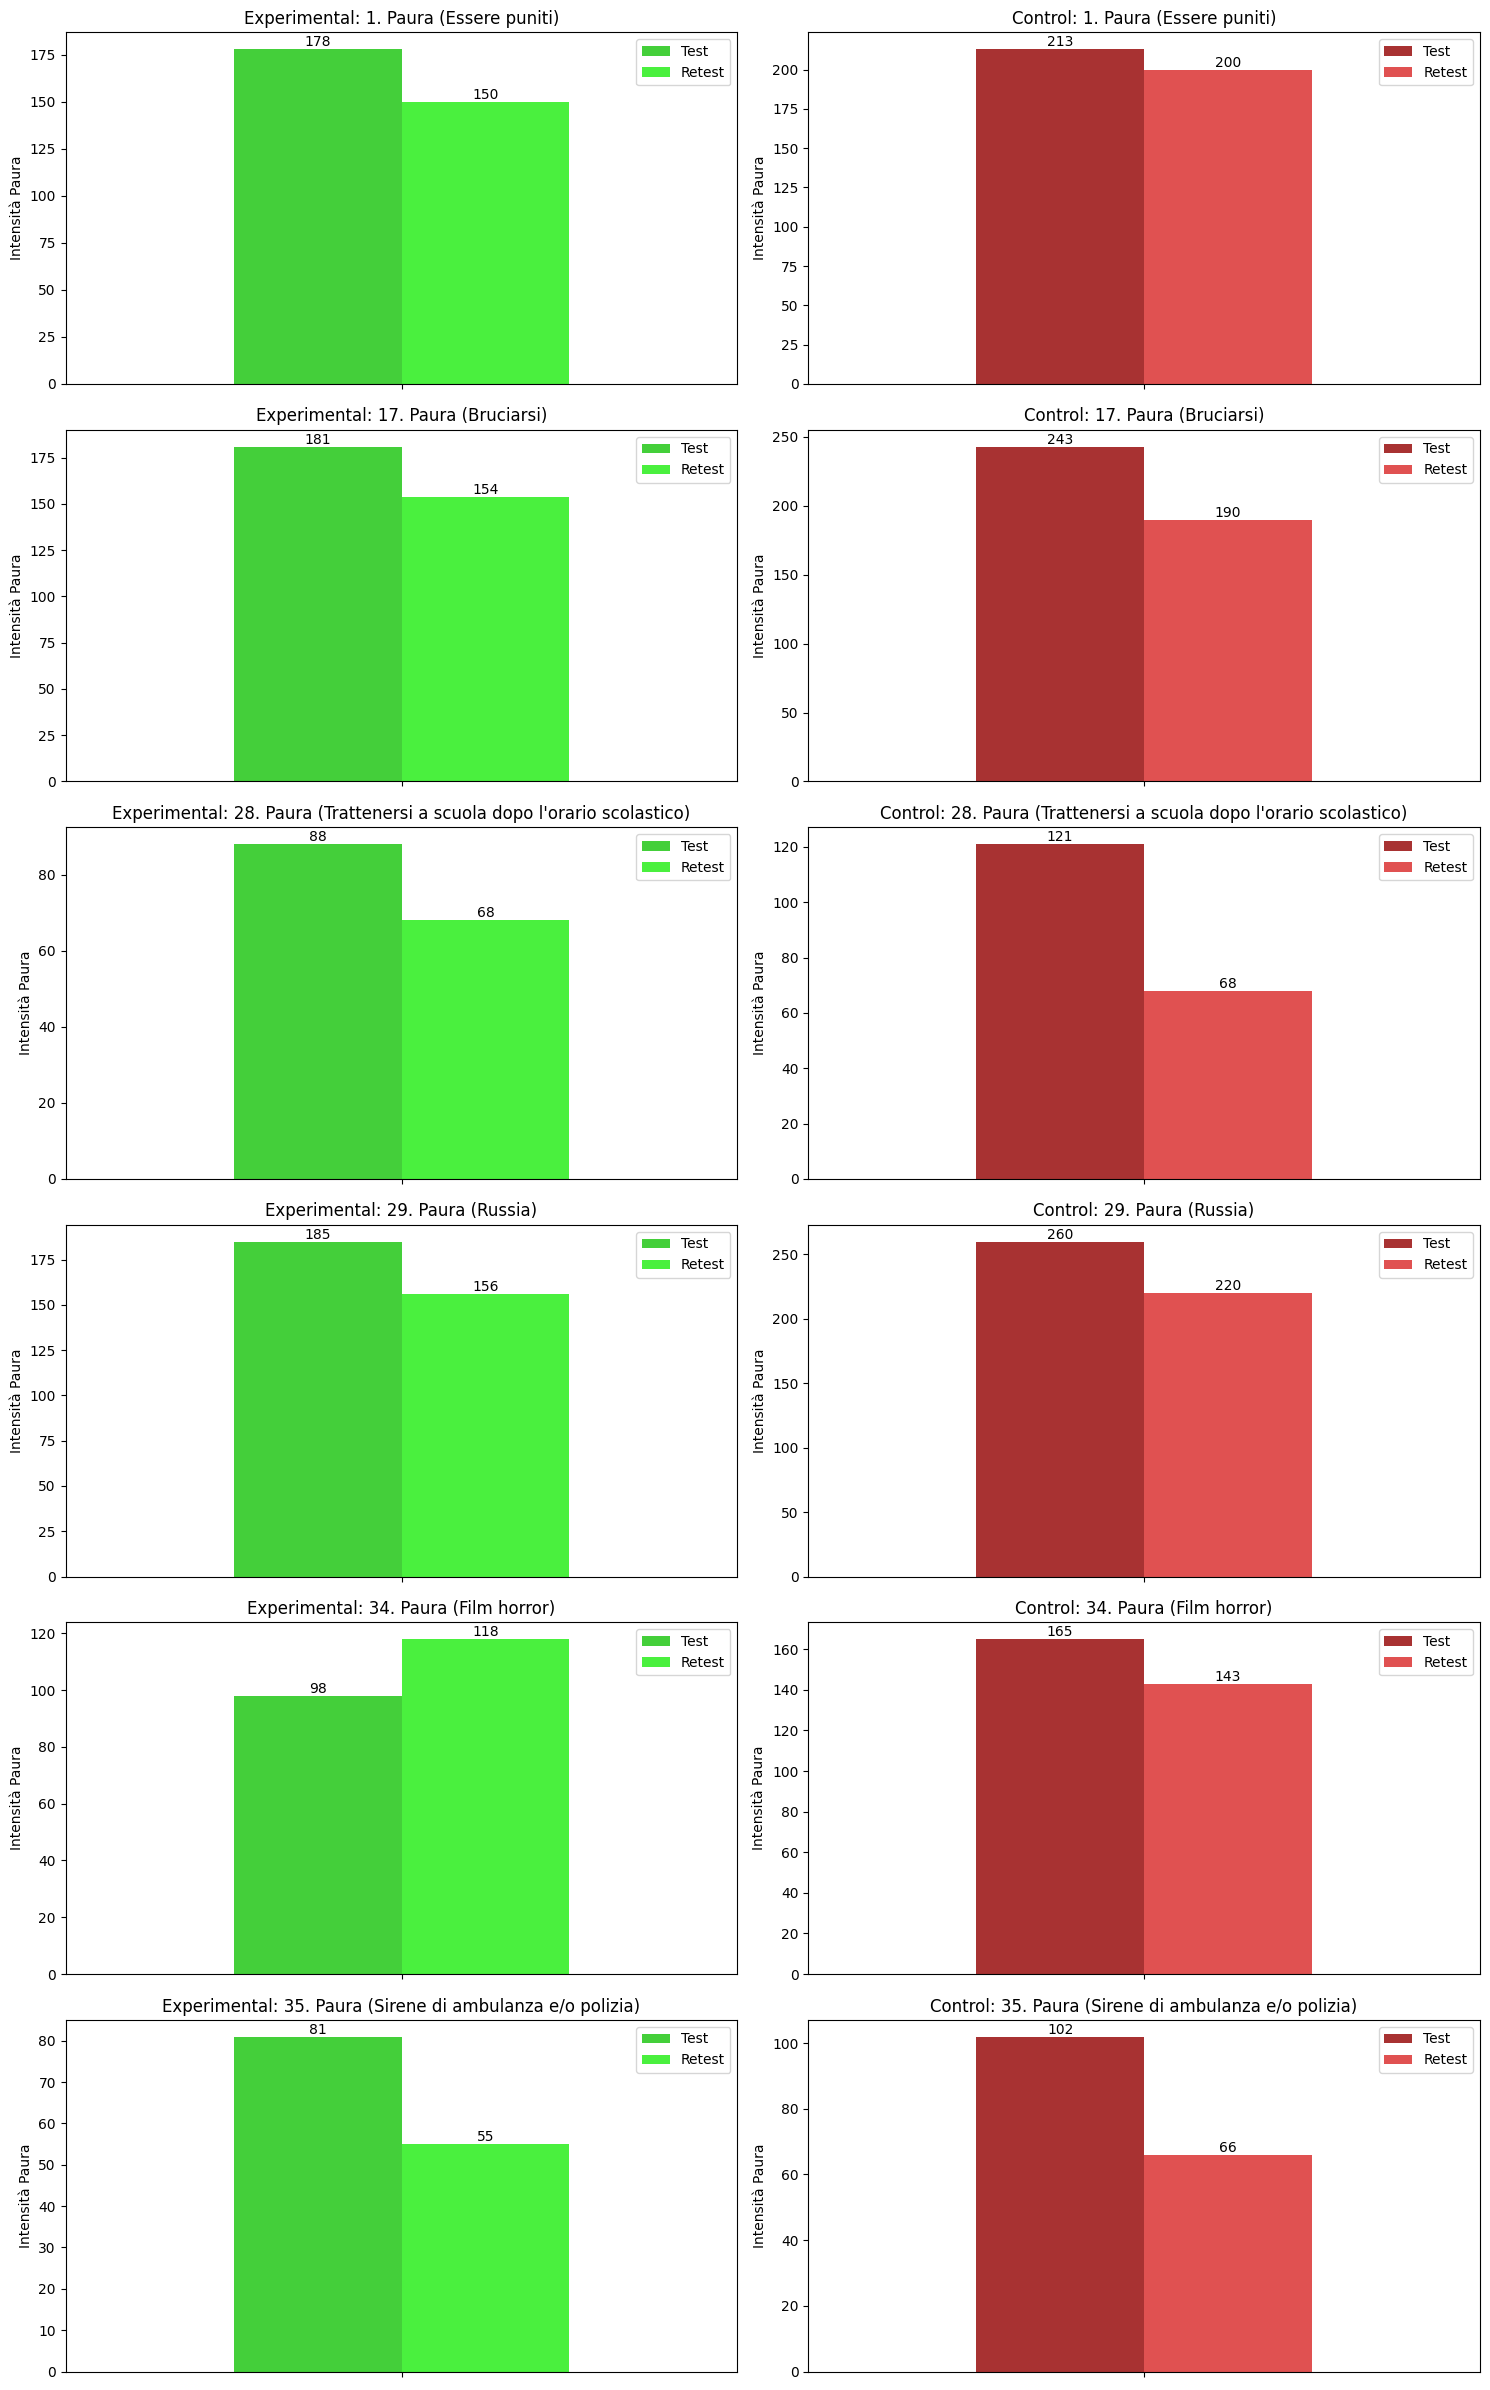

In [79]:
significant_var = np.unique(np.append(alex_fear[alex_fear['Alexander Govern p-value'] < 0.05]['Variable'].to_numpy(), mann_fear[mann_fear['p-value'] < 0.05]['Variable'].to_numpy()))

fig, axs = plt.subplots(len(significant_var), 2, figsize=(15, 4 * len(significant_var)))

colors_experimental = ['#44cf3a', '#4af03e']
colors_control = ['#a83232', '#e05151']

for i, var in enumerate(significant_var):
    # Experimental
    df_f_exp = pd.DataFrame({
        'Test': test_fear_df_experimental_sum[test_fear_df_experimental_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_experimental_sum[retest_fear_df_experimental_sum['item'] == var]['sum']
    })
    bars = df_f_exp.plot(kind='bar', ax=axs[i, 0], color=colors_experimental)
    axs[i, 0].set_title(f'Experimental: {var}')
    axs[i, 0].set_ylabel('Intensità Paura')
    axs[i, 0].set_xticklabels([])  # Remove x-ticks labels

    # Add the data value on top of each bar
    for bar in bars.patches:
        axs[i, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Control
    df_f_ctrl = pd.DataFrame({
        'Test': test_fear_df_control_sum[test_fear_df_control_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_control_sum[retest_fear_df_control_sum['item'] == var]['sum']
    })
    bars = df_f_ctrl.plot(kind='bar', ax=axs[i, 1], color=colors_control)
    axs[i, 1].set_title(f'Control: {var}')
    axs[i, 1].set_ylabel('Intensità Paura')
    axs[i, 1].set_xticklabels([])  # Remove x-ticks labels

    # Add the data value on top of each bar
    for bar in bars.patches:
        axs[i, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./report-output/fear_outcome.png')
plt.show()

In [80]:
# Initialize an empty DataFrame
df_all = pd.DataFrame()

for i, var in enumerate(significant_var):
    # Experimental
    df_f_exp = pd.DataFrame({
        'Test': test_fear_df_experimental_sum[test_fear_df_experimental_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_experimental_sum[retest_fear_df_experimental_sum['item'] == var]['sum']
    })
    df_f_exp['Group'] = 'Experimental'
    df_f_exp['Variable'] = var

    # Control
    df_f_ctrl = pd.DataFrame({
        'Test': test_fear_df_control_sum[test_fear_df_control_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_control_sum[retest_fear_df_control_sum['item'] == var]['sum']
    })
    df_f_ctrl['Group'] = 'Control'
    df_f_ctrl['Variable'] = var

    # Concatenate the dataframes
    df_all = pd.concat([df_all, df_f_exp, df_f_ctrl])

# Reset the index
df_all.reset_index(drop=True, inplace=True)
df_all['Percentage Change'] = 100 - (df_all['Retest'] / df_all['Test']) * 100

# Print the DataFrame
df_all.to_csv('./report-output/fear_outcome.csv', index=False, sep=';')
df_all

Test  Retest         Group  \
0    178     150  Experimental   
1    213     200       Control   
2    181     154  Experimental   
3    243     190       Control   
4     88      68  Experimental   
5    121      68       Control   
6    185     156  Experimental   
7    260     220       Control   
8     98     118  Experimental   
9    165     143       Control   
10    81      55  Experimental   
11   102      66       Control   

                                             Variable  Percentage Change  
0                            1. Paura (Essere puniti)          15.730337  
1                            1. Paura (Essere puniti)           6.103286  
2                               17. Paura (Bruciarsi)          14.917127  
3                               17. Paura (Bruciarsi)          21.810700  
4   28. Paura (Trattenersi a scuola dopo l'orario ...          22.727273  
5   28. Paura (Trattenersi a scuola dopo l'orario ...          43.801653  
6                                  29. Paura (Russia)          15.675676  
7                                  29. Paura (Russia)          15.384615  
8                             34. Paura (Film horror)         -20.408163  
9                             34. Paura (Film horror)          13.333333  
10        35. Paura (Sirene di ambulanza e/o polizia)          32.098765  
11        35. Paura (Sirene di ambulanza e/o polizia)          35.294118

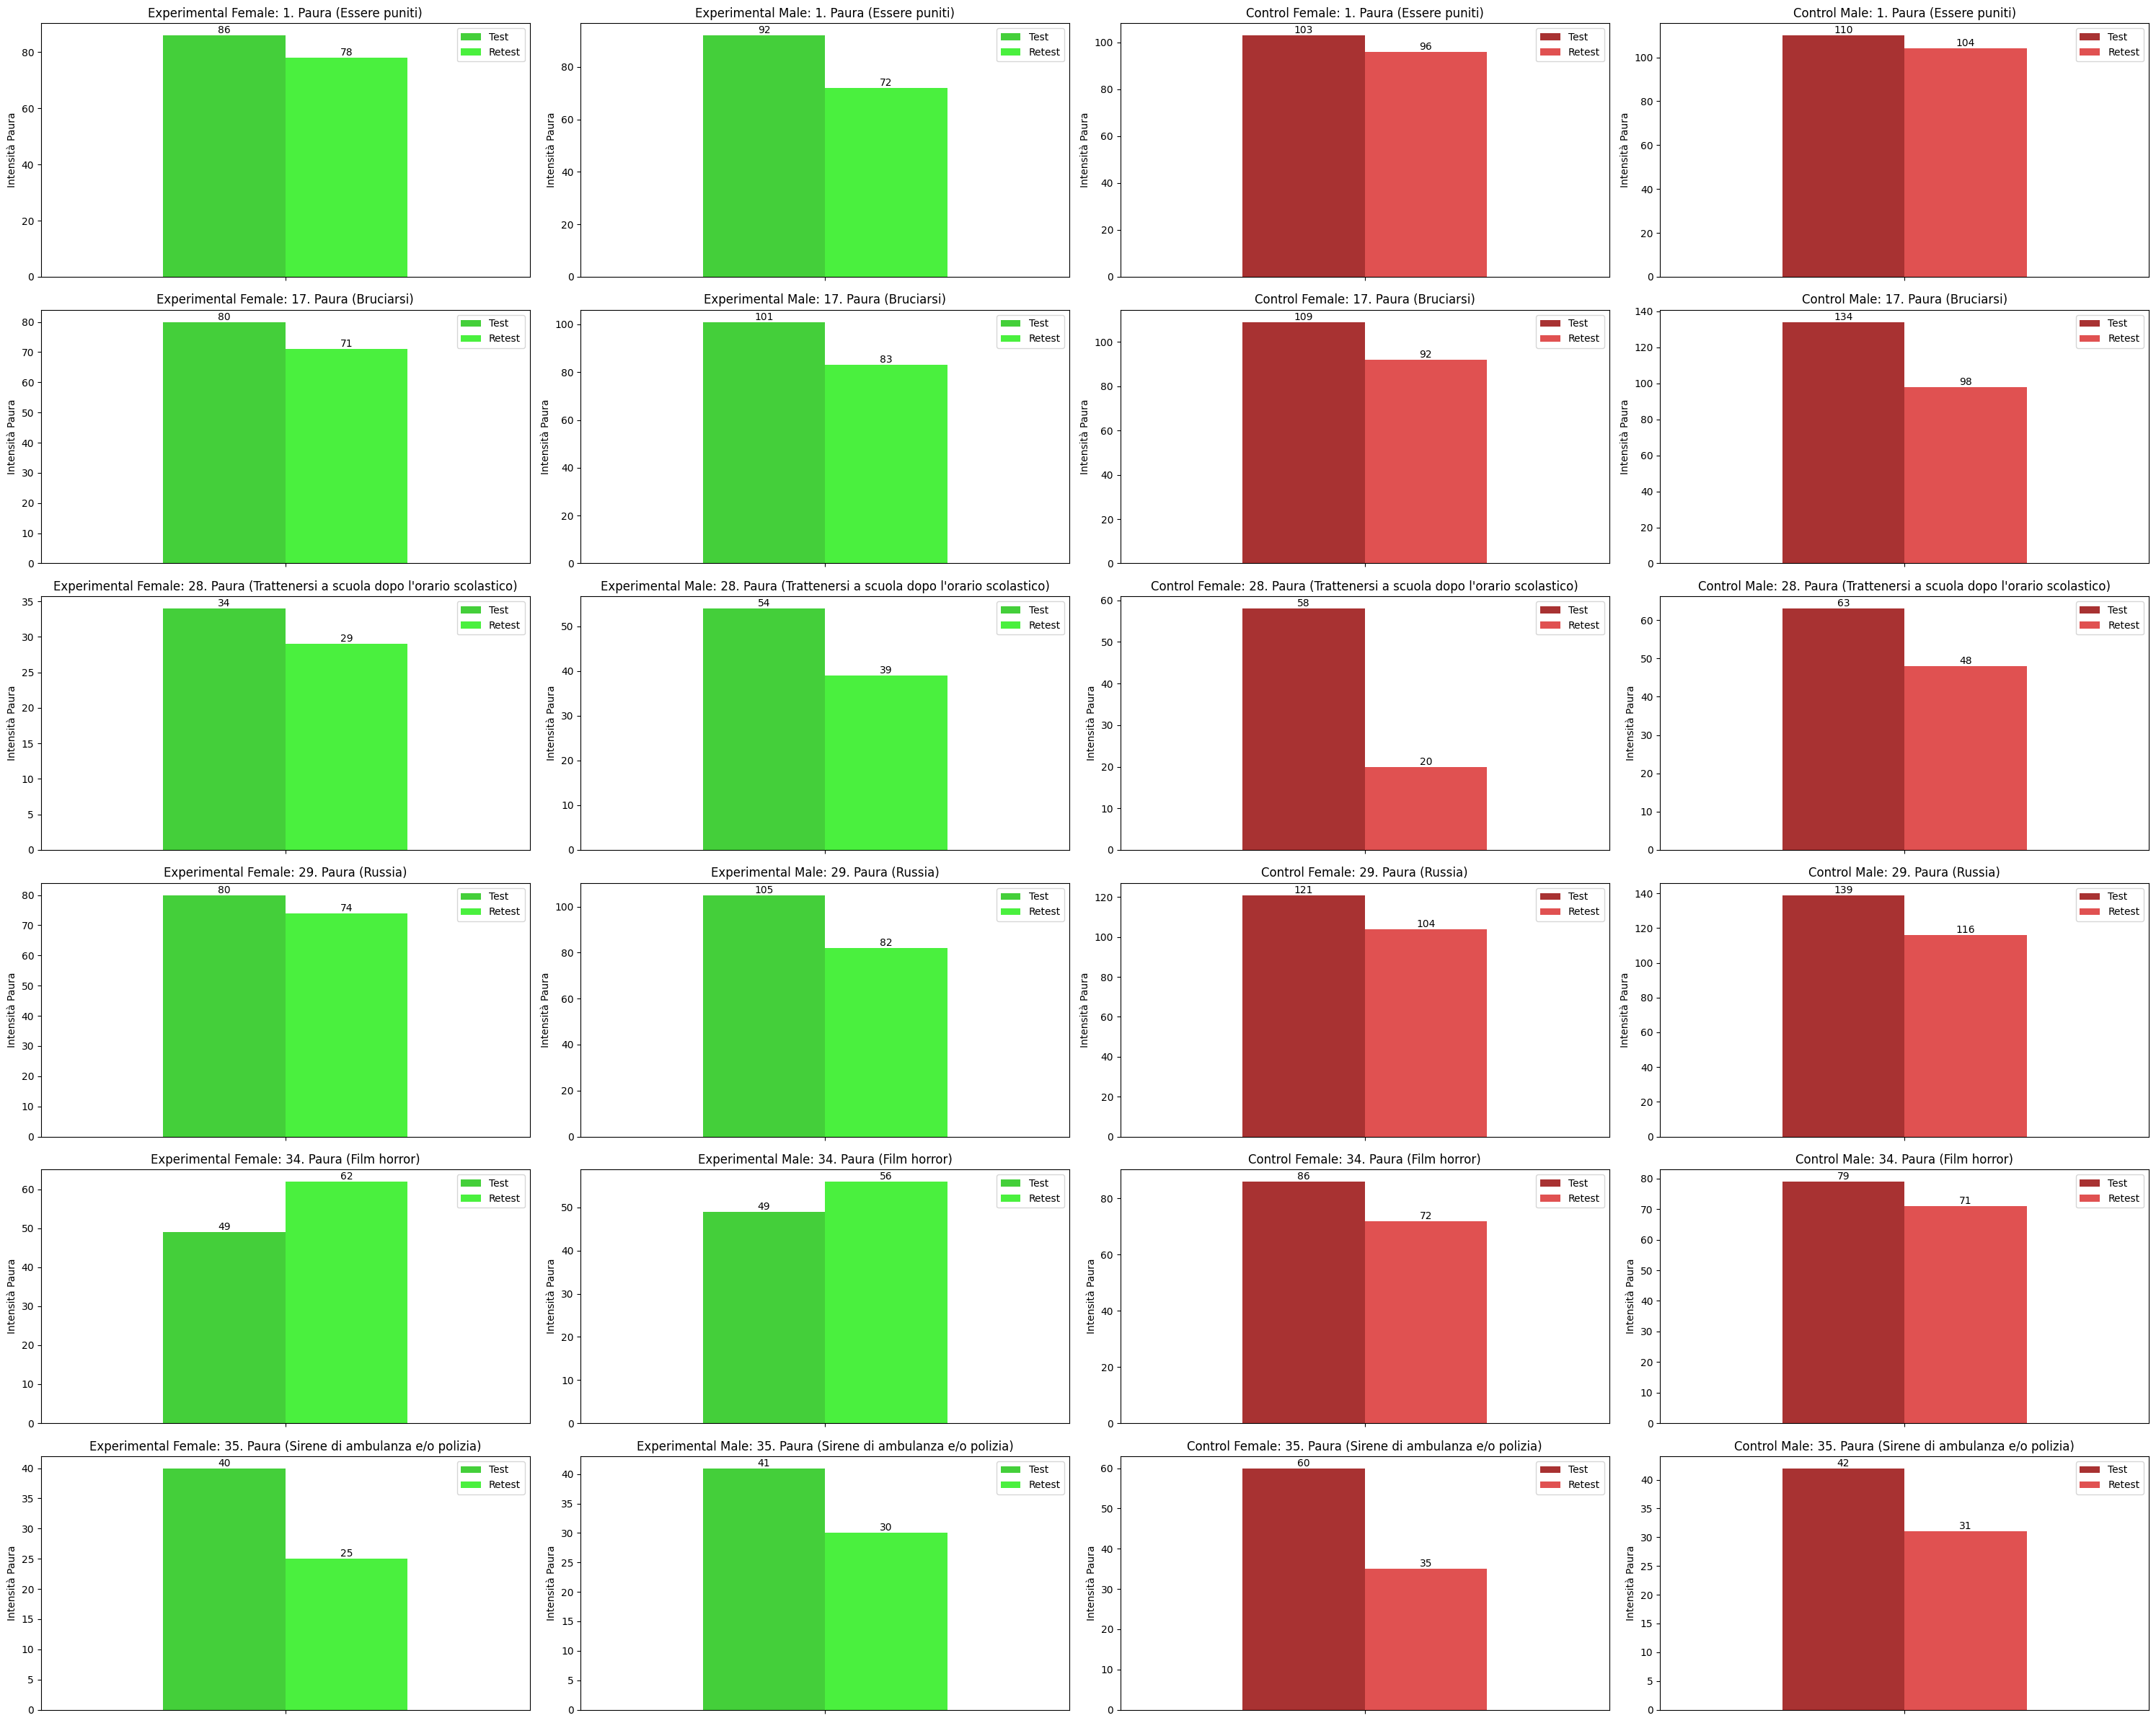

In [81]:
significant_var = np.unique(np.append(alex_fear[alex_fear['Alexander Govern p-value'] < 0.05]['Variable'].to_numpy(), mann_fear[mann_fear['p-value'] < 0.05]['Variable'].to_numpy()))

fig, axs = plt.subplots(len(significant_var), 4, figsize=(30, 4 * len(significant_var)))

colors_experimental = ['#44cf3a', '#4af03e']
colors_control = ['#a83232', '#e05151']

for i, var in enumerate(significant_var):
    # Experimental females
    df_f_exp = pd.DataFrame({
        'Test': test_fear_df_experimental_f_sum[test_fear_df_experimental_f_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_experimental_f_sum[retest_fear_df_experimental_f_sum['item'] == var]['sum']
    })
    bars = df_f_exp.plot(kind='bar', ax=axs[i, 0], color=colors_experimental)
    axs[i, 0].set_title(f'Experimental Female: {var}')
    axs[i, 0].set_ylabel('Intensità Paura')
    axs[i, 0].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Experimental males
    df_m_exp = pd.DataFrame({
        'Test': test_fear_df_experimental_m_sum[test_fear_df_experimental_m_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_experimental_m_sum[retest_fear_df_experimental_m_sum['item'] == var]['sum']
    })
    bars = df_m_exp.plot(kind='bar', ax=axs[i, 1], color=colors_experimental)
    axs[i, 1].set_title(f'Experimental Male: {var}')
    axs[i, 1].set_ylabel('Intensità Paura')
    axs[i, 1].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Control females
    df_f_ctrl = pd.DataFrame({
        'Test': test_fear_df_control_f_sum[test_fear_df_control_f_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_control_f_sum[retest_fear_df_control_f_sum['item'] == var]['sum']
    })
    bars = df_f_ctrl.plot(kind='bar', ax=axs[i, 2], color=colors_control)
    axs[i, 2].set_title(f'Control Female: {var}')
    axs[i, 2].set_ylabel('Intensità Paura')
    axs[i, 2].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 2].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Control males
    df_m_ctrl = pd.DataFrame({
        'Test': test_fear_df_control_m_sum[test_fear_df_control_m_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_control_m_sum[retest_fear_df_control_m_sum['item'] == var]['sum']
    })
    bars = df_m_ctrl.plot(kind='bar', ax=axs[i, 3], color=colors_control)
    axs[i, 3].set_title(f'Control Male: {var}')
    axs[i, 3].set_ylabel('Intensità Paura')
    axs[i, 3].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 3].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./report-output/fear_outcome_m_f.png')
plt.show()

In [82]:
# Initialize an empty DataFrame
df_all = pd.DataFrame()

for i, var in enumerate(significant_var):
    # Experimental
    df_f_exp = pd.DataFrame({
        'Test Female': test_fear_df_experimental_f_sum[test_fear_df_experimental_f_sum['item'] == var]['sum'],
        'Retest Female': retest_fear_df_experimental_f_sum[retest_fear_df_experimental_f_sum['item'] == var]['sum'],
        'Test Male': test_fear_df_experimental_m_sum[test_fear_df_experimental_m_sum['item'] == var]['sum'],
        'Retest Male': retest_fear_df_experimental_m_sum[retest_fear_df_experimental_m_sum['item'] == var]['sum']
    })
    df_f_exp['Group'] = 'Experimental'
    df_f_exp['Variable'] = var

    # Control
    df_f_ctrl = pd.DataFrame({
        'Test Female': test_fear_df_control_f_sum[test_fear_df_control_f_sum['item'] == var]['sum'],
        'Retest Female': retest_fear_df_control_f_sum[retest_fear_df_control_f_sum['item'] == var]['sum'],
        'Test Male': test_fear_df_control_m_sum[test_fear_df_control_m_sum['item'] == var]['sum'],
        'Retest Male': retest_fear_df_control_m_sum[retest_fear_df_control_m_sum['item'] == var]['sum'],
    })
    df_f_ctrl['Group'] = 'Control'
    df_f_ctrl['Variable'] = var

    # Concatenate the dataframes
    df_all = pd.concat([df_all, df_f_exp, df_f_ctrl])

# Reset the index
df_all.reset_index(drop=True, inplace=True)
df_all['Percentage Change Female'] = 100 - (df_all['Retest Female'] / df_all['Test Female']) * 100
df_all['Percentage Change Male'] = 100 - (df_all['Retest Male'] / df_all['Test Male']) * 100

# Print the DataFrame
df_all.to_csv('./report-output/fear_outcome_m_f.csv', index=False, sep=';')
df_all

Test Female  Retest Female  Test Male  Retest Male         Group  \
0            86             78         92           72  Experimental   
1           103             96        110          104       Control   
2            80             71        101           83  Experimental   
3           109             92        134           98       Control   
4            34             29         54           39  Experimental   
5            58             20         63           48       Control   
6            80             74        105           82  Experimental   
7           121            104        139          116       Control   
8            49             62         49           56  Experimental   
9            86             72         79           71       Control   
10           40             25         41           30  Experimental   
11           60             35         42           31       Control   

                                             Variable  \
0                            1. Paura (Essere puniti)   
1                            1. Paura (Essere puniti)   
2                               17. Paura (Bruciarsi)   
3                               17. Paura (Bruciarsi)   
4   28. Paura (Trattenersi a scuola dopo l'orario ...   
5   28. Paura (Trattenersi a scuola dopo l'orario ...   
6                                  29. Paura (Russia)   
7                                  29. Paura (Russia)   
8                             34. Paura (Film horror)   
9                             34. Paura (Film horror)   
10        35. Paura (Sirene di ambulanza e/o polizia)   
11        35. Paura (Sirene di ambulanza e/o polizia)   

    Percentage Change Female  Percentage Change Male  
0                   9.302326               21.739130  
1                   6.796117                5.454545  
2                  11.250000               17.821782  
3                  15.596330               26.865672  
4                  14.705882               27.777778  
5                  65.517241               23.809524  
6                   7.500000               21.904762  
7                  14.049587               16.546763  
8                 -26.530612              -14.285714  
9                  16.279070               10.126582  
10                 37.500000               26.829268  
11                 41.666667               26.190476

In [83]:
time_vs_fear_prec_analysis = [
    ("Tempo sui Videogames", "11. Paura (Serpenti)"),
    ("Tempo sui Videogames", "23. Paura (Fare giochi violenti)"),
    ("Tempo sui Videogames", "33. Paura (Videogames violenti)"),
    ("Tempo sui Videogames Elettronici", "10. Paura (Essere presi in giro)"),
    ("Tempo sui Videogames Elettronici", "11. Paura (Serpenti)"),
    ("Tempo sui Videogames Elettronici", "23. Paura (Fare giochi violenti)"),
    ("Tempo sui Videogames Elettronici", "33. Paura (Videogames violenti)")
]

civil_vs_fear_prec_analysis = [
    ("Senso Civile (Non fare la raccolta differenziata)", "29. Paura (Russia)"),
    ("Senso Civile (Non lavare le mani)", "14. Paura (Allagamenti)"),
    ("Senso Civile (Attraversare con il semaforo rosso)", "5. Paura (Ammalarsi)"),
    ("Senso Civile (Attraversare la strada fuori dalle strisce pedonali)", "5. Paura (Ammalarsi)"),
    ("Senso Civile (Imbrattare i muri ed i mezzi pubblici (treni,pullman))", "11. Paura (Serpenti)"),
    ("Senso Civile (Imbrattare i muri ed i mezzi pubblici (treni,pullman))", "12. Paura (Ladri)"),
    ("Senso Civile (Imbrattare i muri ed i mezzi pubblici (treni,pullman))", "12. Paura (Ladri)"),
    ("Senso Civile (Attraversare la strada fuori dalle strisce pedonali)", "14. Paura (Allagamenti)"),
    ("Senso Civile (Attraversare la strada fuori dalle strisce pedonali)", "18. Paura (Tagliarsi o ferirsi)"),
    ("Senso Civile (Parcheggiare dove è vietato)", "23. Paura (Fare giochi violenti)"),
    ("Senso Civile (Parcheggiare dove è vietato)", "36. Paura (Terremoti)"),
    ("Senso Civile (Non allacciare le cinture di sicurezza)", "5. Paura (Ammalarsi)"),
    ("Senso Civile (Non allacciare le cinture di sicurezza)", "27. Paura (Il sangue)"),
    ("Senso Civile (Dire le parolacce)", "3. Paura (Andare in ospedale)"),
    ("Senso Civile (Dire le parolacce)", "11. Paura (Serpenti)"),
    ("Senso Civile (Dire le parolacce)", "23. Paura (Fare giochi violenti)"),
    ("Senso Civile (Dire le parolacce)", "27. Paura (Il sangue)"),
    ("Senso Civile (Dire le parolacce)", "39. Paura (Terroristi)"),
    ("Senso Civile (Non aiutare i compagni/e e le altre persone in difficoltà)", "24. Paura (Ucraina)"),
    ("Senso Civile (Non aiutare i compagni/e e le altre persone in difficoltà)", "30. Paura (Pandemia)"),
    ("Senso Civile (Non aiutare i compagni/e e le altre persone in difficoltà)", "33. Paura (Videogames violenti)"),
    ("Senso Civile (Danneggiare gli oggetti altrui)", "30. Paura (Pandemia)"),
    ("Senso Civile (Calpestare i fiori)", "33. Paura (Videogames violenti)"),
    ("Senso Civile (Parcheggiare dove è vietato)", "33. Paura (Videogames violenti)"),
    ("Senso Civile (Usare il cellulare a pranzo o cena)", "33. Paura (Videogames violenti)"),
    ("Senso Civile (Dire le parolacce)", "33. Paura (Videogames violenti)"),
    ("Senso Civile (Imbrogliare nel gioco)", "33. Paura (Videogames violenti)"),
    ("Senso Civile (Imbrattare i muri ed i mezzi pubblici (treni,pullman))", "36. Paura (Terremoti)"),
    ("Senso Civile (Spintonare i propri compagni/e)", "39. Paura (Terroristi)")
]

In [84]:
import re

# Calculate the number of plots
n = len(civil_vs_fear_prec_analysis)
ncols = 4  # Set the number of columns to 4
nrows = n  # Set the number of rows to n

# Create a figure and axes
fig, ax = plt.subplots(nrows, ncols, figsize=(35, nrows*5))

# Set the suptitle
fig.suptitle("Significant Results", y=1.02)

# Flatten the axes array if there is more than one plot
if n > 1:
    ax = ax.flatten()

# Iterate over the tuples in civil_vs_fear_prec_analysis
for index, (col1, col2) in enumerate(civil_vs_fear_prec_analysis):
    # Create contingency tables for experimental data, experimental retest data, control data, and control retest data
    contingency_table_experimental = pd.crosstab(test_fear_df_experimental[col2], test_civil_df_experimental[col1])
    contingency_table_experimental_retest = pd.crosstab(retest_fear_df_experimental[col2], retest_civil_df_experimental[col1])
    contingency_table_control = pd.crosstab(test_fear_df_control[col2], test_civil_df_control[col1])
    contingency_table_control_retest = pd.crosstab(retest_fear_df_control[col2], retest_civil_df_control[col1])

    safe_col1 = re.sub('[^A-Za-z0-9]+', '_', col1)
    safe_col2 = re.sub('[^A-Za-z0-9]+', '_', col2)

    filename = './report-output/civic_vs_fear/{}_vs_{}_experimental_test.csv'.format(safe_col1, safe_col2)
    contingency_table_experimental.to_csv(filename, sep=';')

    filename = './report-output/civic_vs_fear/{}_vs_{}_experimental_retest.csv'.format(safe_col1, safe_col2)
    contingency_table_experimental_retest.to_csv(filename, sep=';')

    filename = './report-output/civic_vs_fear/{}_vs_{}_control_test.csv'.format(safe_col1, safe_col2)
    contingency_table_control.to_csv(filename, sep=';')

    filename = './report-output/civic_vs_fear/{}_vs_{}_control_retest.csv'.format(safe_col1, safe_col2)
    contingency_table_control_retest.to_csv(filename, sep=';')

    # Create stacked bar charts on the current subplot for each data set
    contingency_table_experimental.plot(kind='bar', stacked=True, ax=ax[4*index] if n > 1 else ax)
    ax[4*index if n > 1 else ax].set_title(f"Experimental: {col1} and {col2}")

    contingency_table_experimental_retest.plot(kind='bar', stacked=True, ax=ax[4*index+1] if n > 1 else ax)
    ax[4*index+1 if n > 1 else ax].set_title(f"Experimental Retest: {col1} and {col2}")

    contingency_table_control.plot(kind='bar', stacked=True, ax=ax[4*index+2] if n > 1 else ax)
    ax[4*index+2 if n > 1 else ax].set_title(f"Control: {col1} and {col2}")

    contingency_table_control_retest.plot(kind='bar', stacked=True, ax=ax[4*index+3] if n > 1 else ax)
    ax[4*index+3 if n > 1 else ax].set_title(f"Control Retest: {col1} and {col2}")

    # Add x-ticks for all plots
    for i in [4*index, 4*index+1, 4*index+2, 4*index+3]:
        ax[i if n > 1 else ax].set_xticks(range(len(contingency_table_experimental.index)))
        ax[i if n > 1 else ax].set_xticklabels(['Nessuna', 'Poca paura', 'Tanta paura'], rotation=45)
        ax[i if n > 1 else ax].legend(loc='upper left', bbox_to_anchor=(1.0, 1), labels=['Indifferente', 'Poco grave', 'Gravissimo'])

# Remove the unused subplots
if n > 1:
    for i in range(4*n, nrows*ncols):
        fig.delaxes(ax[i])

plt.tight_layout()
plt.savefig('./report-output/civil_vs_fear_test_retest_experimental_control.png')
plt.show()

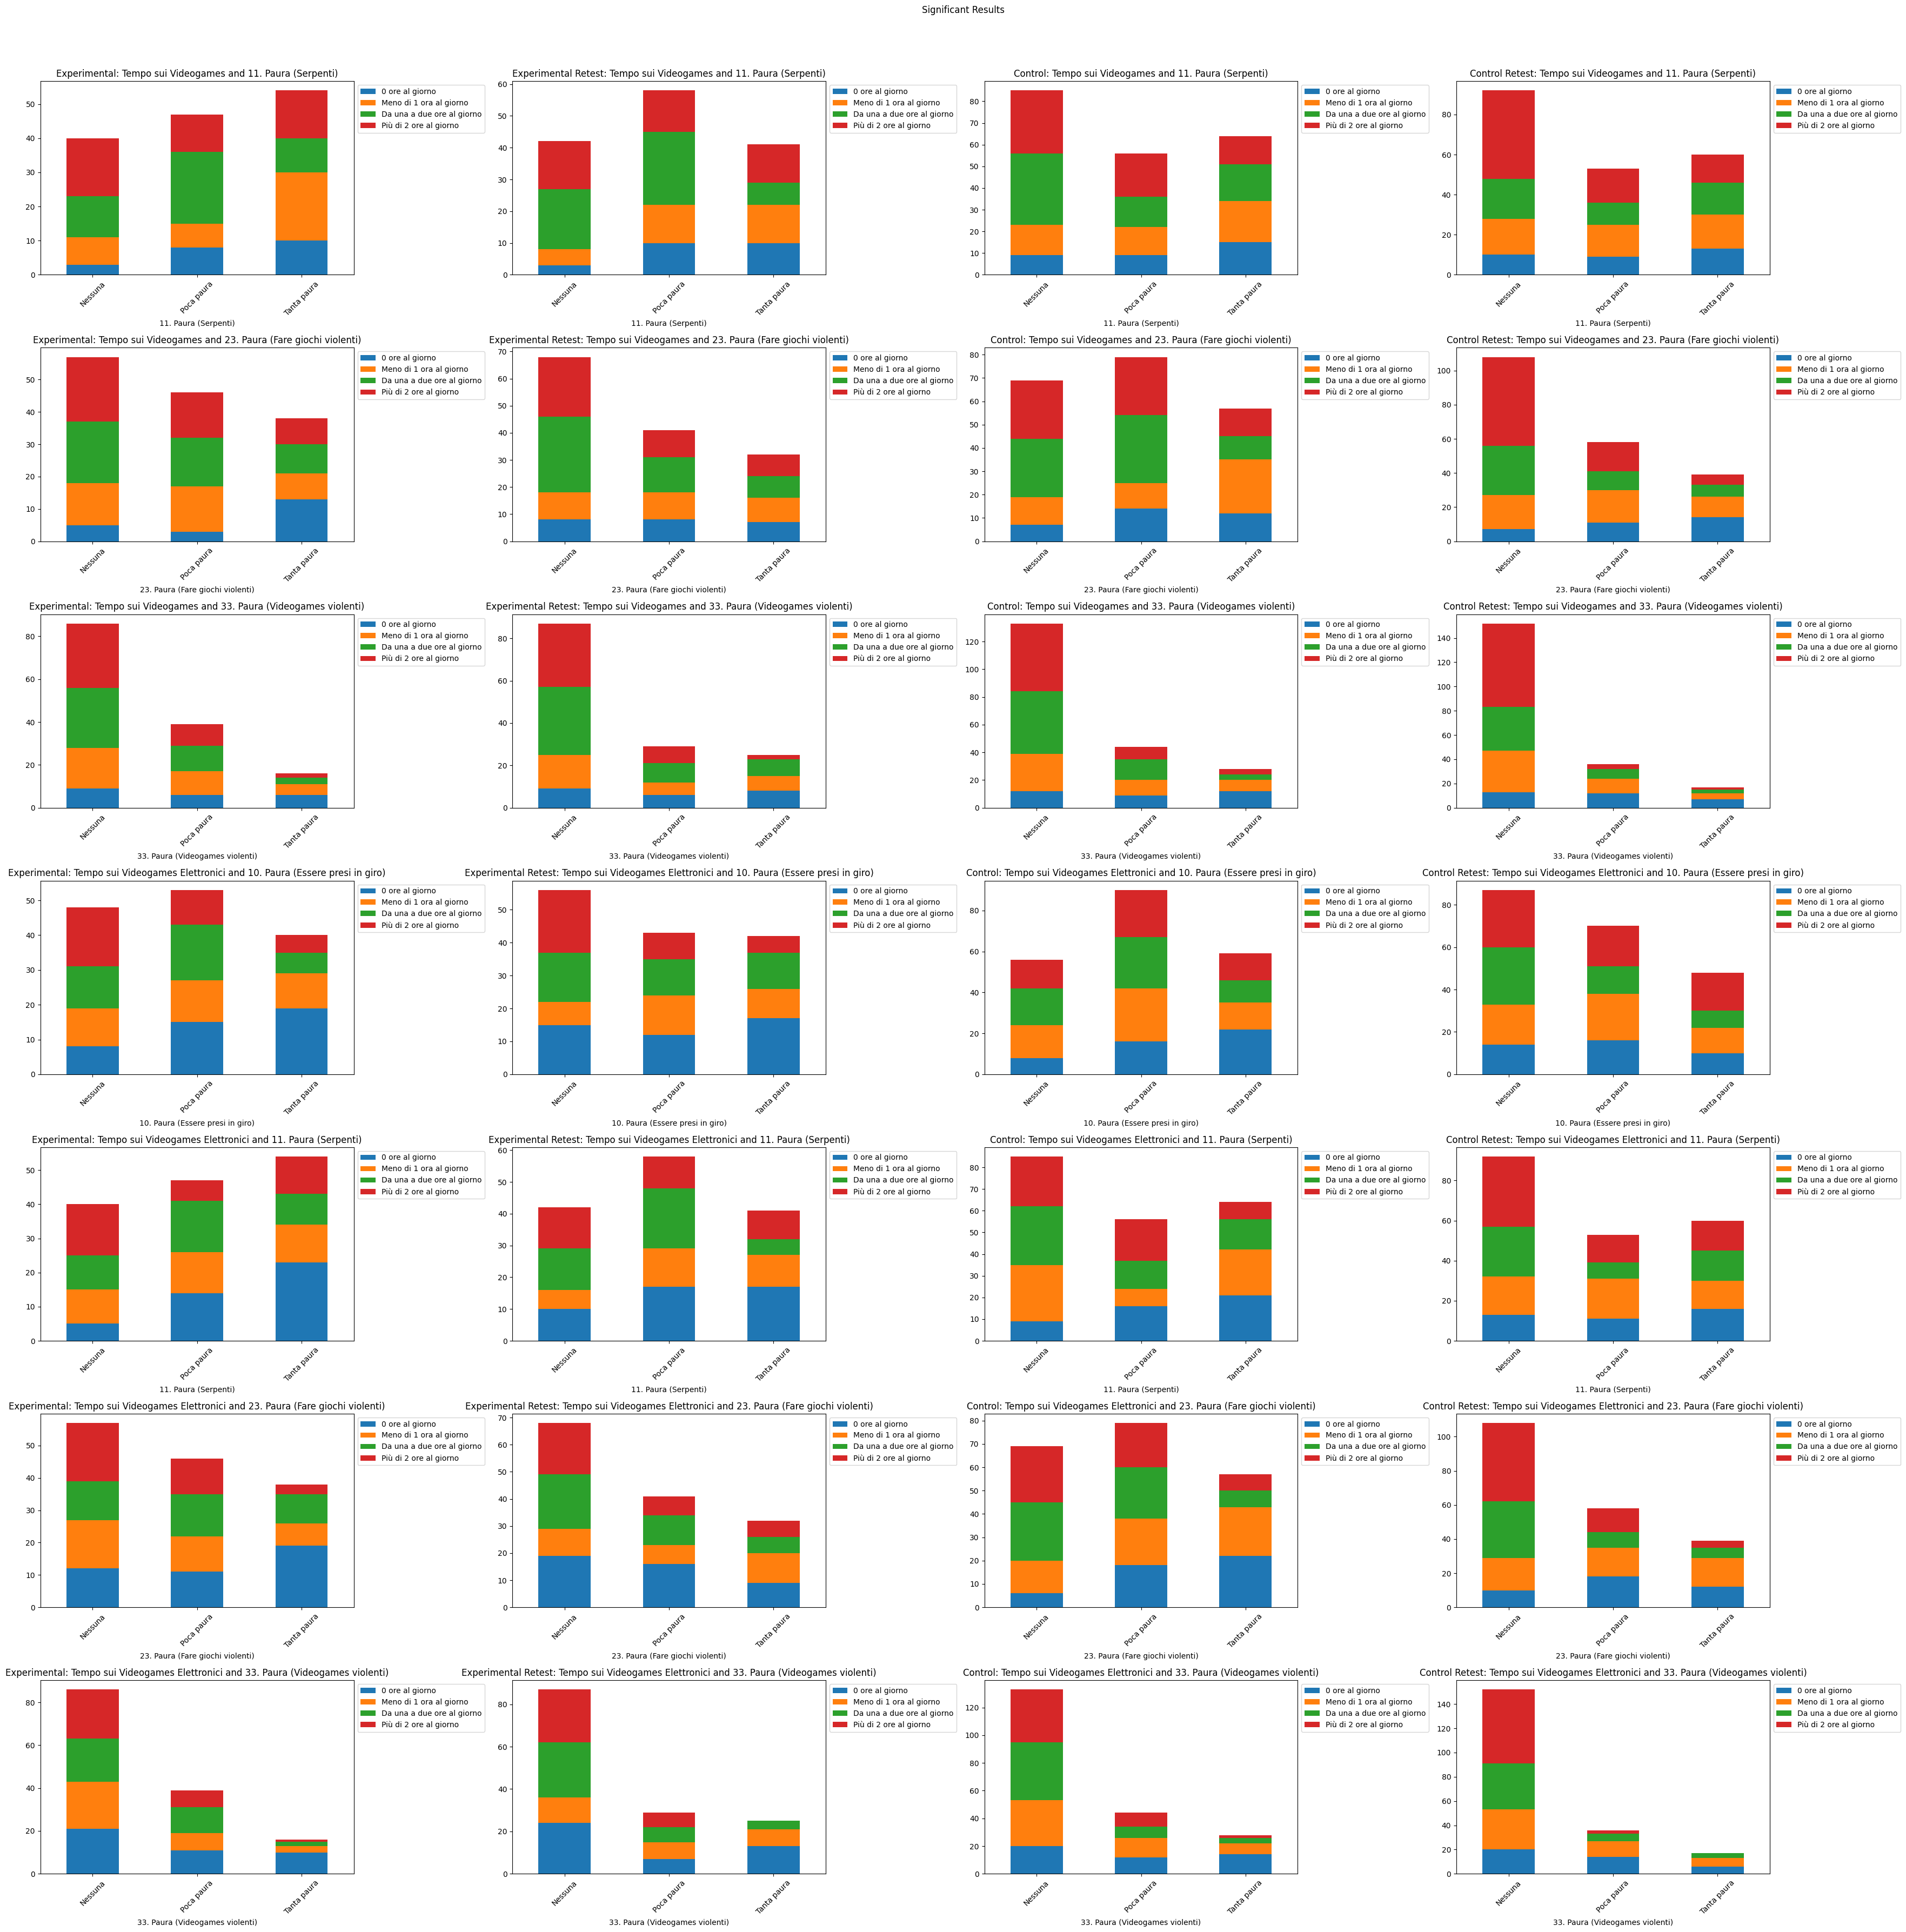

In [91]:
# Calculate the number of plots
n = len(time_vs_fear_prec_analysis)
ncols = 4  # Set the number of columns to 4
nrows = n  # Set the number of rows to n

# Create a figure and axes
fig, ax = plt.subplots(nrows, ncols, figsize=(35, nrows*5))

# Set the suptitle
fig.suptitle("Significant Results", y=1.02)

# Flatten the axes array if there is more than one plot
if n > 1:
    ax = ax.flatten()

# Iterate over the tuples in time_vs_fear_prec_analysis
for index, (col1, col2) in enumerate(time_vs_fear_prec_analysis):
    # Create contingency tables for experimental data, experimental retest data, control data, and control retest data
    contingency_table_experimental = pd.crosstab(test_fear_df_experimental[col2], test_time_df_experimental[col1])
    contingency_table_experimental_retest = pd.crosstab(retest_fear_df_experimental[col2], retest_time_df_experimental[col1])
    contingency_table_control = pd.crosstab(test_fear_df_control[col2], test_time_df_control[col1])
    contingency_table_control_retest = pd.crosstab(retest_fear_df_control[col2], retest_time_df_control[col1])

    safe_col1 = re.sub('[^A-Za-z0-9]+', '_', col1)
    safe_col2 = re.sub('[^A-Za-z0-9]+', '_', col2)

    filename = './report-output/time_vs_fear/{}_vs_{}_experimental_test.csv'.format(safe_col1, safe_col2)
    contingency_table_experimental.to_csv(filename, sep=';')

    filename = './report-output/time_vs_fear/{}_vs_{}_experimental_retest.csv'.format(safe_col1, safe_col2)
    contingency_table_experimental_retest.to_csv(filename, sep=';')

    filename = './report-output/time_vs_fear/{}_vs_{}_control_test.csv'.format(safe_col1, safe_col2)
    contingency_table_control.to_csv(filename, sep=';')

    filename = './report-output/time_vs_fear/{}_vs_{}_control_retest.csv'.format(safe_col1, safe_col2)
    contingency_table_control_retest.to_csv(filename, sep=';')


    # Create stacked bar charts on the current subplot for each data set
    contingency_table_experimental.plot(kind='bar', stacked=True, ax=ax[4*index] if n > 1 else ax)
    ax[4*index if n > 1 else ax].set_title(f"Experimental: {col1} and {col2}")

    contingency_table_experimental_retest.plot(kind='bar', stacked=True, ax=ax[4*index+1] if n > 1 else ax)
    ax[4*index+1 if n > 1 else ax].set_title(f"Experimental Retest: {col1} and {col2}")

    contingency_table_control.plot(kind='bar', stacked=True, ax=ax[4*index+2] if n > 1 else ax)
    ax[4*index+2 if n > 1 else ax].set_title(f"Control: {col1} and {col2}")

    contingency_table_control_retest.plot(kind='bar', stacked=True, ax=ax[4*index+3] if n > 1 else ax)
    ax[4*index+3 if n > 1 else ax].set_title(f"Control Retest: {col1} and {col2}")

    # Add x-ticks for all plots
    for i in [4*index, 4*index+1, 4*index+2, 4*index+3]:
        ax[i if n > 1 else ax].set_xticks(range(len(contingency_table_experimental.index)))
        ax[i if n > 1 else ax].set_xticklabels(['Nessuna', 'Poca paura', 'Tanta paura'], rotation=45)
        ax[i if n > 1 else ax].legend(loc='upper left', bbox_to_anchor=(1.0, 1), labels=['0 ore al giorno', 'Meno di 1 ora al giorno', 'Da una a due ore al giorno', 'Più di 2 ore al giorno'])

# Remove the unused subplots
if n > 1:
    for i in range(4*n, nrows*ncols):
        fig.delaxes(ax[i])

plt.tight_layout()
plt.savefig('./report-output/time_vs_fear_test_retest_experimental_control.png')
plt.show()

# Civil

In [ ]:
test_civil_df_experimental = test_civil_df_experimental.sample(n=len(retest_civil_df_experimental.index))

## Frequency Analysis - Experimental

In [86]:
fa_civil_experimental = frequency_analysis(test_civil_df_experimental, retest_civil_df_experimental)
fa_civil_experimental.to_csv('./report-output/fa_civil_experimental.csv', index=False, sep=';')
fa_civil_experimental

Variable          Frequency Test  \
0          Senso Civile (Accendere fuochi nei boschi)   {2: 120, 1: 19, 0: 6}   
1   Senso Civile (Attraversare con il semaforo rosso)   {2: 74, 1: 51, 0: 20}   
2   Senso Civile (Attraversare la strada fuori dal...   {2: 52, 0: 48, 1: 45}   
3                   Senso Civile (Calpestare i fiori)   {1: 62, 2: 60, 0: 23}   
4       Senso Civile (Danneggiare gli oggetti altrui)   {2: 94, 1: 41, 0: 10}   
5                    Senso Civile (Dire le parolacce)   {2: 74, 1: 53, 0: 18}   
6          Senso Civile (Gettare le carte per strada)   {2: 106, 1: 32, 0: 7}   
7   Senso Civile (Gettare mozziconi di sigarette a...   {2: 120, 1: 17, 0: 8}   
8   Senso Civile (Imbrattare i muri ed i mezzi pub...   {2: 92, 1: 42, 0: 11}   
9                Senso Civile (Imbrogliare nel gioco)   {1: 63, 0: 43, 2: 39}   
10      Senso Civile (Lasciare i rifiuti dove capita)   {2: 118, 1: 19, 0: 8}   
11             Senso Civile (Maltrattare gli animali)         {2: 133, 1: 12}   
12  Senso Civile (Non aiutare i compagni/e e le al...  {2: 101, 1: 34, 0: 10}   
13  Senso Civile (Non allacciare le cinture di sic...   {2: 74, 1: 54, 0: 17}   
14  Senso Civile (Non fare la raccolta differenziata)   {2: 97, 1: 38, 0: 10}   
15              Senso Civile (Non indossare il casco)   {2: 78, 1: 51, 0: 16}   
16                  Senso Civile (Non lavare le mani)   {1: 72, 2: 41, 0: 32}   
17         Senso Civile (Parcheggiare dove è vietato)   {2: 69, 1: 60, 0: 16}   
18  Senso Civile (Prendere in giro i propri compag...   {2: 106, 1: 32, 0: 7}   
19      Senso Civile (Spintonare i propri compagni/e)   {2: 103, 1: 33, 0: 9}   
20  Senso Civile (Usare il cellulare a pranzo o cena)   {1: 52, 0: 47, 2: 46}   
21         Senso Civile (Usare il cellulare a scuola)   {2: 93, 1: 36, 0: 16}   
22           Senso Civile (Viaggiare senza biglietto)   {2: 77, 1: 52, 0: 16}   

          Frequency Retest              Difference  
0   {2: 112, 1: 19, 0: 10}     {0: 4, 1: 0, 2: -8}  
1    {2: 65, 1: 51, 0: 25}     {0: 5, 1: 0, 2: -9}  
2    {1: 67, 0: 46, 2: 28}  {0: -2, 1: 22, 2: -24}  
3    {1: 58, 2: 49, 0: 34}  {0: 11, 1: -4, 2: -11}  
4    {2: 84, 1: 46, 0: 11}    {0: 1, 1: 5, 2: -10}  
5    {2: 57, 1: 44, 0: 40}  {0: 22, 1: -9, 2: -17}  
6    {2: 78, 1: 48, 0: 15}   {0: 8, 1: 16, 2: -28}  
7    {2: 98, 1: 32, 0: 11}   {0: 3, 1: 15, 2: -22}  
8    {2: 68, 1: 55, 0: 18}   {0: 7, 1: 13, 2: -24}  
9    {0: 60, 1: 50, 2: 31}  {0: 17, 1: -13, 2: -8}  
10  {2: 103, 1: 28, 0: 10}    {0: 2, 1: 9, 2: -15}  
11   {2: 121, 1: 13, 0: 7}    {0: 7, 1: 1, 2: -12}  
12   {2: 91, 1: 38, 0: 12}    {0: 2, 1: 4, 2: -10}  
13   {1: 57, 2: 52, 0: 32}   {0: 15, 1: 3, 2: -22}  
14   {2: 72, 1: 48, 0: 21}  {0: 11, 1: 10, 2: -25}  
15   {2: 72, 1: 45, 0: 24}    {0: 8, 1: -6, 2: -6}  
16   {1: 66, 0: 40, 2: 35}    {0: 8, 1: -6, 2: -6}  
17   {2: 60, 1: 57, 0: 24}    {0: 8, 1: -3, 2: -9}  
18  {2: 102, 1: 25, 0: 14}    {0: 7, 1: -7, 2: -4}  
19   {2: 91, 1: 38, 0: 12}    {0: 3, 1: 5, 2: -12}  
20   {0: 58, 1: 55, 2: 28}   {0: 11, 1: 3, 2: -18}  
21   {2: 69, 1: 44, 0: 28}   {0: 12, 1: 8, 2: -24}  
22   {2: 78, 1: 42, 0: 21}    {0: 5, 1: -10, 2: 1}

## Frequency Analysis - Control

In [87]:
fa_civil_control = frequency_analysis(test_civil_df_control, retest_civil_df_control)
fa_civil_control.to_csv('./report-output/fa_civil_control.csv', index=False, sep=';')
fa_civil_control

Variable          Frequency Test  \
0          Senso Civile (Accendere fuochi nei boschi)  {2: 180, 1: 14, 0: 11}   
1   Senso Civile (Attraversare con il semaforo rosso)  {2: 103, 1: 72, 0: 30}   
2   Senso Civile (Attraversare la strada fuori dal...   {1: 87, 0: 61, 2: 57}   
3                   Senso Civile (Calpestare i fiori)   {1: 88, 2: 87, 0: 30}   
4       Senso Civile (Danneggiare gli oggetti altrui)  {2: 130, 1: 65, 0: 10}   
5                    Senso Civile (Dire le parolacce)  {2: 105, 1: 70, 0: 30}   
6          Senso Civile (Gettare le carte per strada)   {2: 142, 1: 56, 0: 7}   
7   Senso Civile (Gettare mozziconi di sigarette a...   {2: 151, 1: 46, 0: 8}   
8   Senso Civile (Imbrattare i muri ed i mezzi pub...  {2: 109, 1: 75, 0: 21}   
9                Senso Civile (Imbrogliare nel gioco)   {1: 97, 0: 74, 2: 34}   
10      Senso Civile (Lasciare i rifiuti dove capita)   {2: 160, 1: 41, 0: 4}   
11             Senso Civile (Maltrattare gli animali)    {2: 196, 1: 6, 0: 3}   
12  Senso Civile (Non aiutare i compagni/e e le al...   {2: 146, 1: 54, 0: 5}   
13  Senso Civile (Non allacciare le cinture di sic...  {2: 101, 1: 71, 0: 33}   
14  Senso Civile (Non fare la raccolta differenziata)  {2: 130, 1: 64, 0: 11}   
15              Senso Civile (Non indossare il casco)  {2: 127, 1: 59, 0: 19}   
16                  Senso Civile (Non lavare le mani)   {1: 97, 2: 58, 0: 50}   
17         Senso Civile (Parcheggiare dove è vietato)   {1: 94, 2: 93, 0: 18}   
18  Senso Civile (Prendere in giro i propri compag...   {2: 170, 1: 31, 0: 4}   
19      Senso Civile (Spintonare i propri compagni/e)   {2: 130, 1: 66, 0: 9}   
20  Senso Civile (Usare il cellulare a pranzo o cena)   {1: 96, 0: 65, 2: 44}   
21         Senso Civile (Usare il cellulare a scuola)  {2: 128, 1: 52, 0: 25}   
22           Senso Civile (Viaggiare senza biglietto)  {2: 103, 1: 82, 0: 20}   

          Frequency Retest              Difference  
0   {2: 166, 1: 24, 0: 15}   {0: 4, 1: 10, 2: -14}  
1    {1: 91, 2: 80, 0: 34}   {0: 4, 1: 19, 2: -23}  
2    {1: 94, 0: 74, 2: 37}   {0: 13, 1: 7, 2: -20}  
3    {1: 98, 2: 60, 0: 47}  {0: 17, 1: 10, 2: -27}  
4   {2: 114, 1: 80, 0: 11}   {0: 1, 1: 15, 2: -16}  
5    {2: 74, 1: 74, 0: 57}   {0: 27, 1: 4, 2: -31}  
6   {2: 129, 1: 63, 0: 13}    {0: 6, 1: 7, 2: -13}  
7   {2: 150, 1: 40, 0: 15}    {0: 7, 1: -6, 2: -1}  
8    {2: 92, 1: 84, 0: 29}    {0: 8, 1: 9, 2: -17}  
9    {0: 94, 1: 80, 2: 31}  {0: 20, 1: -17, 2: -3}  
10  {2: 156, 1: 39, 0: 10}    {0: 6, 1: -2, 2: -4}  
11   {2: 180, 1: 21, 0: 4}   {0: 1, 1: 15, 2: -16}  
12  {2: 128, 1: 64, 0: 13}   {0: 8, 1: 10, 2: -18}  
13   {1: 88, 2: 69, 0: 48}  {0: 15, 1: 17, 2: -32}  
14  {2: 108, 1: 81, 0: 16}   {0: 5, 1: 17, 2: -22}  
15   {2: 96, 1: 78, 0: 31}  {0: 12, 1: 19, 2: -31}  
16  {1: 102, 0: 61, 2: 42}   {0: 11, 1: 5, 2: -16}  
17  {1: 112, 2: 61, 0: 32}  {0: 14, 1: 18, 2: -32}  
18  {2: 148, 1: 41, 0: 16}  {0: 12, 1: 10, 2: -22}  
19  {2: 117, 1: 69, 0: 19}   {0: 10, 1: 3, 2: -13}  
20   {1: 84, 0: 84, 2: 37}  {0: 19, 1: -12, 2: -7}  
21   {2: 87, 1: 73, 0: 45}  {0: 20, 1: 21, 2: -41}  
22   {1: 86, 2: 85, 0: 34}   {0: 14, 1: 4, 2: -18}

## Alexander Govern - H0: Stessa Media, H1: Media Diversa

In [88]:
alex_civil = test_alexandergovern(test_civil_df_experimental, retest_civil_df_experimental).sort_values(by='Alexander Govern p-value')
alex_civil.to_csv('./report-output/alexander_govern_civil.csv', index=False, sep=';')
alex_civil

Variable  Alexander Govern Stat  \
6          Senso Civile (Gettare le carte per strada)               9.974538   
14  Senso Civile (Non fare la raccolta differenziata)               8.699698   
5                    Senso Civile (Dire le parolacce)               8.463334   
13  Senso Civile (Non allacciare le cinture di sic...               8.377865   
21         Senso Civile (Usare il cellulare a scuola)               7.493983   
8   Senso Civile (Imbrattare i muri ed i mezzi pub...               6.584828   
7   Senso Civile (Gettare mozziconi di sigarette a...               4.978406   
11             Senso Civile (Maltrattare gli animali)               4.971731   
20  Senso Civile (Usare il cellulare a pranzo o cena)               4.932978   
9                Senso Civile (Imbrogliare nel gioco)               3.814292   
3                   Senso Civile (Calpestare i fiori)               2.870217   
2   Senso Civile (Attraversare la strada fuori dal...               2.839092   
10      Senso Civile (Lasciare i rifiuti dove capita)               2.092164   
17         Senso Civile (Parcheggiare dove è vietato)               1.740040   
19      Senso Civile (Spintonare i propri compagni/e)               1.419611   
16                  Senso Civile (Non lavare le mani)               1.302617   
1   Senso Civile (Attraversare con il semaforo rosso)               1.040793   
15              Senso Civile (Non indossare il casco)               1.039686   
0          Senso Civile (Accendere fuochi nei boschi)               0.937671   
12  Senso Civile (Non aiutare i compagni/e e le al...               0.811157   
4       Senso Civile (Danneggiare gli oggetti altrui)               0.680249   
18  Senso Civile (Prendere in giro i propri compag...               0.649687   
22           Senso Civile (Viaggiare senza biglietto)               0.038049   

    Alexander Govern p-value  
6                   0.001587  
14                  0.003183  
5                   0.003624  
13                  0.003798  
21                  0.006191  
8                   0.010285  
7                   0.025666  
11                  0.025765  
20                  0.026349  
9                   0.050817  
3                   0.090233  
2                   0.091996  
10                  0.148056  
17                  0.187134  
19                  0.233467  
16                  0.253736  
1                   0.307637  
15                  0.307894  
0                   0.332878  
12                  0.367778  
4                   0.409501  
18                  0.420224  
22                  0.845344

## Mannwhitneyu - H0: Stessa distribuzione, H1: Distribuzione Diversa

In [89]:
mann_civil = mannwhitneyu_test(test_civil_df_experimental, retest_civil_df_experimental).sort_values(by='p-value')
mann_civil.to_csv('./report-output/mannwhitneyu_civil.csv', index=False, sep=';')
mann_civil

Variable  Statistic   p-value
6          Senso Civile (Gettare le carte per strada)    12112.5  0.000678
14  Senso Civile (Non fare la raccolta differenziata)    12000.0  0.001836
13  Senso Civile (Non allacciare le cinture di sic...    12049.0  0.002323
21         Senso Civile (Usare il cellulare a scuola)    11928.5  0.003078
5                    Senso Civile (Dire le parolacce)    11971.0  0.003457
8   Senso Civile (Imbrattare i muri ed i mezzi pub...    11854.0  0.004235
7   Senso Civile (Gettare mozziconi di sigarette a...    11543.0  0.005524
20  Senso Civile (Usare il cellulare a pranzo o cena)    11651.0  0.014782
9                Senso Civile (Imbrogliare nel gioco)    11539.5  0.022193
11             Senso Civile (Maltrattare gli animali)    10868.5  0.045643
3                   Senso Civile (Calpestare i fiori)    11287.0  0.050706
10      Senso Civile (Lasciare i rifiuti dove capita)    11057.0  0.051314
2   Senso Civile (Attraversare la strada fuori dal...    11285.5  0.052898
17         Senso Civile (Parcheggiare dove è vietato)    11001.0  0.111978
19      Senso Civile (Spintonare i propri compagni/e)    10913.5  0.114218
16                  Senso Civile (Non lavare le mani)    10959.5  0.127054
1   Senso Civile (Attraversare con il semaforo rosso)    10854.5  0.161642
12  Senso Civile (Non aiutare i compagni/e e le al...    10759.5  0.176265
4       Senso Civile (Danneggiare gli oggetti altrui)    10755.0  0.186677
15              Senso Civile (Non indossare il casco)    10753.5  0.200381
0          Senso Civile (Accendere fuochi nei boschi)    10600.5  0.213952
18  Senso Civile (Prendere in giro i propri compag...    10437.0  0.347235
22           Senso Civile (Viaggiare senza biglietto)    10206.0  0.510821

## Data Understanding

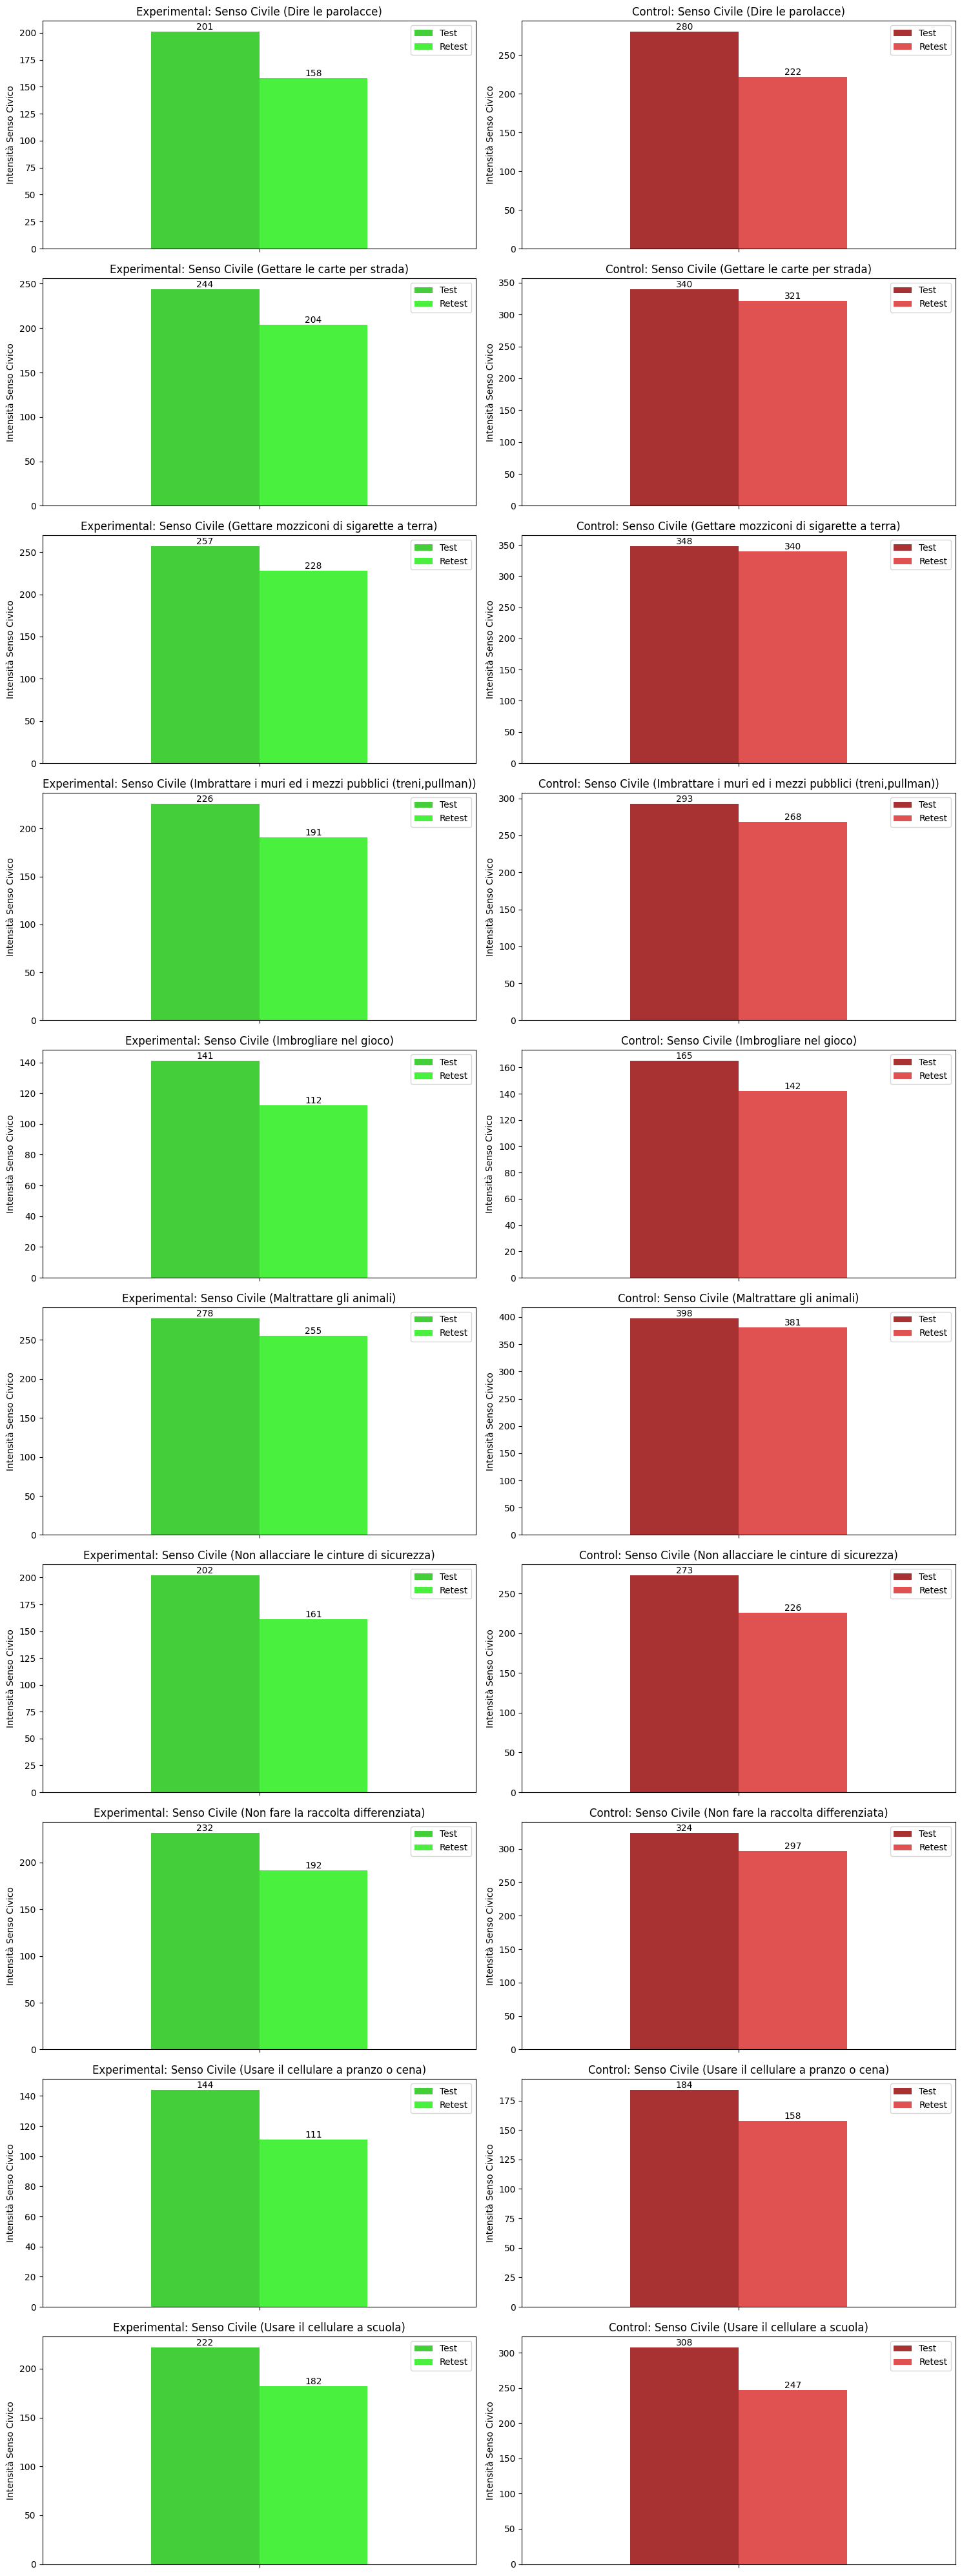

In [95]:
significant_var = np.unique(np.append(alex_civil[alex_civil['Alexander Govern p-value'] < 0.05]['Variable'].to_numpy(), mann_civil[mann_civil['p-value'] < 0.05]['Variable'].to_numpy()))

fig, axs = plt.subplots(len(significant_var), 2, figsize=(15, 4 * len(significant_var)))

colors_experimental = ['#44cf3a', '#4af03e']
colors_control = ['#a83232', '#e05151']

for i, var in enumerate(significant_var):
    # Experimental
    df_f_exp = pd.DataFrame({
        'Test': test_civil_df_experimental_sum[test_civil_df_experimental_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_experimental_sum[retest_civil_df_experimental_sum['item'] == var]['sum']
    })
    bars = df_f_exp.plot(kind='bar', ax=axs[i, 0], color=colors_experimental)
    axs[i, 0].set_title(f'Experimental: {var}')
    axs[i, 0].set_ylabel('Intensità Senso Civico')
    axs[i, 0].set_xticklabels([])  # Remove x-ticks labels

    # Add the data value on top of each bar
    for bar in bars.patches:
        axs[i, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Control
    df_f_ctrl = pd.DataFrame({
        'Test': test_civil_df_control_sum[test_civil_df_control_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_control_sum[retest_civil_df_control_sum['item'] == var]['sum']
    })
    bars = df_f_ctrl.plot(kind='bar', ax=axs[i, 1], color=colors_control)
    axs[i, 1].set_title(f'Control: {var}')
    axs[i, 1].set_ylabel('Intensità Senso Civico')
    axs[i, 1].set_xticklabels([])  # Remove x-ticks labels

    # Add the data value on top of each bar
    for bar in bars.patches:
        axs[i, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./report-output/civil_outcome.png')
plt.show()

In [92]:
# Initialize an empty DataFrame
df_all = pd.DataFrame()

for i, var in enumerate(significant_var):
    # Experimental
    df_f_exp = pd.DataFrame({
        'Test': test_civil_df_experimental_sum[test_civil_df_experimental_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_experimental_sum[retest_civil_df_experimental_sum['item'] == var]['sum']
    })
    df_f_exp['Group'] = 'Experimental'
    df_f_exp['Variable'] = var

    # Control
    df_f_ctrl = pd.DataFrame({
        'Test': test_civil_df_control_sum[test_civil_df_control_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_control_sum[retest_civil_df_control_sum['item'] == var]['sum']
    })
    df_f_ctrl['Group'] = 'Control'
    df_f_ctrl['Variable'] = var

    # Concatenate the dataframes
    df_all = pd.concat([df_all, df_f_exp, df_f_ctrl])

# Reset the index
df_all.reset_index(drop=True, inplace=True)
df_all['Percentage Change'] = 100 - (df_all['Retest'] / df_all['Test']) * 100

# Print the DataFrame
df_all.to_csv('./report-output/civil_outcome.csv', index=False, sep=';')
df_all

Test  Retest         Group  \
0    201     158  Experimental   
1    280     222       Control   
2    244     204  Experimental   
3    340     321       Control   
4    257     228  Experimental   
5    348     340       Control   
6    226     191  Experimental   
7    293     268       Control   
8    141     112  Experimental   
9    165     142       Control   
10   278     255  Experimental   
11   398     381       Control   
12   202     161  Experimental   
13   273     226       Control   
14   232     192  Experimental   
15   324     297       Control   
16   144     111  Experimental   
17   184     158       Control   
18   222     182  Experimental   
19   308     247       Control   

                                             Variable  Percentage Change  
0                    Senso Civile (Dire le parolacce)          21.393035  
1                    Senso Civile (Dire le parolacce)          20.714286  
2          Senso Civile (Gettare le carte per strada)          16.393443  
3          Senso Civile (Gettare le carte per strada)           5.588235  
4   Senso Civile (Gettare mozziconi di sigarette a...          11.284047  
5   Senso Civile (Gettare mozziconi di sigarette a...           2.298851  
6   Senso Civile (Imbrattare i muri ed i mezzi pub...          15.486726  
7   Senso Civile (Imbrattare i muri ed i mezzi pub...           8.532423  
8                Senso Civile (Imbrogliare nel gioco)          20.567376  
9                Senso Civile (Imbrogliare nel gioco)          13.939394  
10             Senso Civile (Maltrattare gli animali)           8.273381  
11             Senso Civile (Maltrattare gli animali)           4.271357  
12  Senso Civile (Non allacciare le cinture di sic...          20.297030  
13  Senso Civile (Non allacciare le cinture di sic...          17.216117  
14  Senso Civile (Non fare la raccolta differenziata)          17.241379  
15  Senso Civile (Non fare la raccolta differenziata)           8.333333  
16  Senso Civile (Usare il cellulare a pranzo o cena)          22.916667  
17  Senso Civile (Usare il cellulare a pranzo o cena)          14.130435  
18         Senso Civile (Usare il cellulare a scuola)          18.018018  
19         Senso Civile (Usare il cellulare a scuola)          19.805195

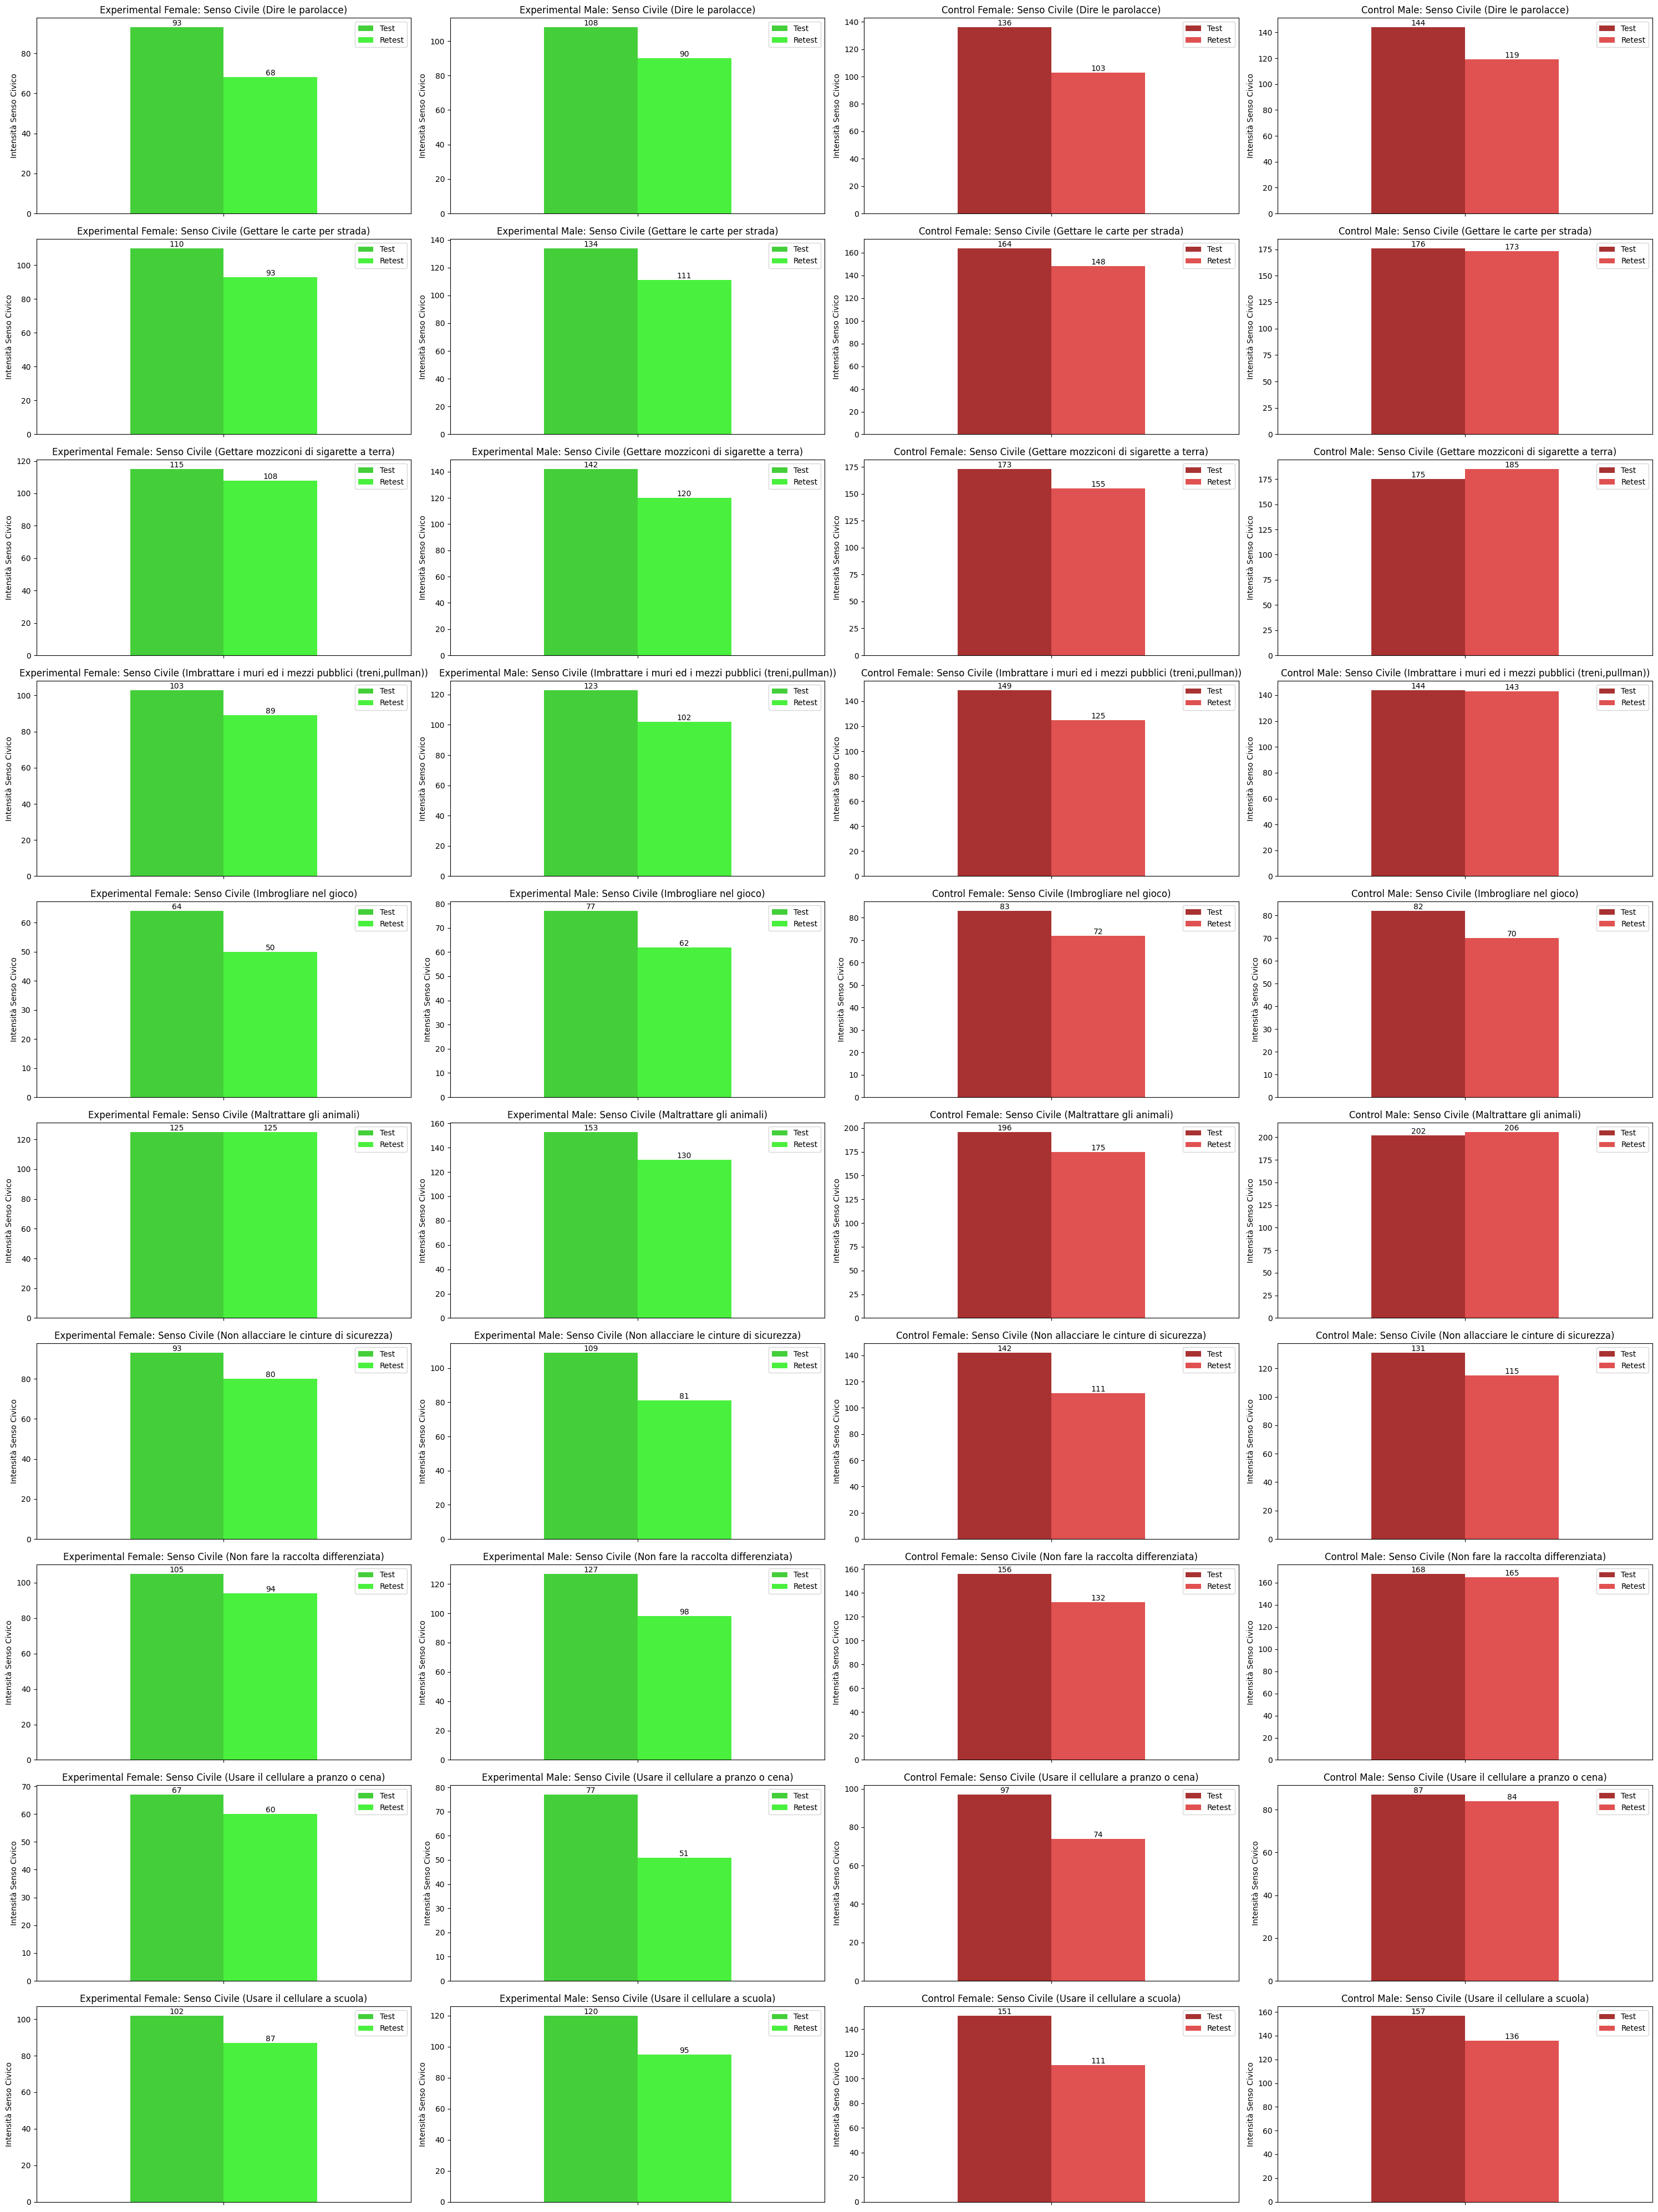

In [94]:
significant_var = np.unique(np.append(alex_civil[alex_civil['Alexander Govern p-value'] < 0.05]['Variable'].to_numpy(), mann_civil[mann_civil['p-value'] < 0.05]['Variable'].to_numpy()))

fig, axs = plt.subplots(len(significant_var), 4, figsize=(30, 4 * len(significant_var)))

colors_experimental = ['#44cf3a', '#4af03e']
colors_control = ['#a83232', '#e05151']

for i, var in enumerate(significant_var):
    # Experimental females
    df_f_exp = pd.DataFrame({
        'Test': test_civil_df_experimental_f_sum[test_civil_df_experimental_f_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_experimental_f_sum[retest_civil_df_experimental_f_sum['item'] == var]['sum']
    })
    bars = df_f_exp.plot(kind='bar', ax=axs[i, 0], color=colors_experimental)
    axs[i, 0].set_title(f'Experimental Female: {var}')
    axs[i, 0].set_ylabel('Intensità Senso Civico')
    axs[i, 0].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Experimental males
    df_m_exp = pd.DataFrame({
        'Test': test_civil_df_experimental_m_sum[test_civil_df_experimental_m_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_experimental_m_sum[retest_civil_df_experimental_m_sum['item'] == var]['sum']
    })
    bars = df_m_exp.plot(kind='bar', ax=axs[i, 1], color=colors_experimental)
    axs[i, 1].set_title(f'Experimental Male: {var}')
    axs[i, 1].set_ylabel('Intensità Senso Civico')
    axs[i, 1].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Control females
    df_f_ctrl = pd.DataFrame({
        'Test': test_civil_df_control_f_sum[test_civil_df_control_f_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_control_f_sum[retest_civil_df_control_f_sum['item'] == var]['sum']
    })
    bars = df_f_ctrl.plot(kind='bar', ax=axs[i, 2], color=colors_control)
    axs[i, 2].set_title(f'Control Female: {var}')
    axs[i, 2].set_ylabel('Intensità Senso Civico')
    axs[i, 2].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 2].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Control males
    df_m_ctrl = pd.DataFrame({
        'Test': test_civil_df_control_m_sum[test_civil_df_control_m_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_control_m_sum[retest_civil_df_control_m_sum['item'] == var]['sum']
    })
    bars = df_m_ctrl.plot(kind='bar', ax=axs[i, 3], color=colors_control)
    axs[i, 3].set_title(f'Control Male: {var}')
    axs[i, 3].set_ylabel('Intensità Senso Civico')
    axs[i, 3].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 3].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./report-output/civil_outcome_m_f.png')
plt.show()

In [96]:
# Initialize an empty DataFrame
df_all = pd.DataFrame()

for i, var in enumerate(significant_var):
    # Experimental
    df_f_exp = pd.DataFrame({
        'Test Female': test_civil_df_experimental_f_sum[test_civil_df_experimental_f_sum['item'] == var]['sum'],
        'Retest Female': retest_civil_df_experimental_f_sum[retest_civil_df_experimental_f_sum['item'] == var]['sum'],
        'Test Male': test_civil_df_experimental_m_sum[test_civil_df_experimental_m_sum['item'] == var]['sum'],
        'Retest Male': retest_civil_df_experimental_m_sum[retest_civil_df_experimental_m_sum['item'] == var]['sum']
    })
    df_f_exp['Group'] = 'Experimental'
    df_f_exp['Variable'] = var

    # Control
    df_f_ctrl = pd.DataFrame({
        'Test Female': test_civil_df_control_f_sum[test_civil_df_control_f_sum['item'] == var]['sum'],
        'Retest Female': retest_civil_df_control_f_sum[retest_civil_df_control_f_sum['item'] == var]['sum'],
        'Test Male': test_civil_df_control_m_sum[test_civil_df_control_m_sum['item'] == var]['sum'],
        'Retest Male': retest_civil_df_control_m_sum[retest_civil_df_control_m_sum['item'] == var]['sum'],
    })
    df_f_ctrl['Group'] = 'Control'
    df_f_ctrl['Variable'] = var

    # Concatenate the dataframes
    df_all = pd.concat([df_all, df_f_exp, df_f_ctrl])

# Reset the index
df_all.reset_index(drop=True, inplace=True)
df_all['Percentage Change Female'] = 100 - (df_all['Retest Female'] / df_all['Test Female']) * 100
df_all['Percentage Change Male'] = 100 - (df_all['Retest Male'] / df_all['Test Male']) * 100

# Print the DataFrame
df_all.to_csv('./report-output/civil_outcome_m_f.csv', index=False, sep=';')
df_all

Test Female  Retest Female  Test Male  Retest Male         Group  \
0            93             68        108           90  Experimental   
1           136            103        144          119       Control   
2           110             93        134          111  Experimental   
3           164            148        176          173       Control   
4           115            108        142          120  Experimental   
5           173            155        175          185       Control   
6           103             89        123          102  Experimental   
7           149            125        144          143       Control   
8            64             50         77           62  Experimental   
9            83             72         82           70       Control   
10          125            125        153          130  Experimental   
11          196            175        202          206       Control   
12           93             80        109           81  Experimental   
13          142            111        131          115       Control   
14          105             94        127           98  Experimental   
15          156            132        168          165       Control   
16           67             60         77           51  Experimental   
17           97             74         87           84       Control   
18          102             87        120           95  Experimental   
19          151            111        157          136       Control   

                                             Variable  \
0                    Senso Civile (Dire le parolacce)   
1                    Senso Civile (Dire le parolacce)   
2          Senso Civile (Gettare le carte per strada)   
3          Senso Civile (Gettare le carte per strada)   
4   Senso Civile (Gettare mozziconi di sigarette a...   
5   Senso Civile (Gettare mozziconi di sigarette a...   
6   Senso Civile (Imbrattare i muri ed i mezzi pub...   
7   Senso Civile (Imbrattare i muri ed i mezzi pub...   
8                Senso Civile (Imbrogliare nel gioco)   
9                Senso Civile (Imbrogliare nel gioco)   
10             Senso Civile (Maltrattare gli animali)   
11             Senso Civile (Maltrattare gli animali)   
12  Senso Civile (Non allacciare le cinture di sic...   
13  Senso Civile (Non allacciare le cinture di sic...   
14  Senso Civile (Non fare la raccolta differenziata)   
15  Senso Civile (Non fare la raccolta differenziata)   
16  Senso Civile (Usare il cellulare a pranzo o cena)   
17  Senso Civile (Usare il cellulare a pranzo o cena)   
18         Senso Civile (Usare il cellulare a scuola)   
19         Senso Civile (Usare il cellulare a scuola)   

    Percentage Change Female  Percentage Change Male  
0                  26.881720               16.666667  
1                  24.264706               17.361111  
2                  15.454545               17.164179  
3                   9.756098                1.704545  
4                   6.086957               15.492958  
5                  10.404624               -5.714286  
6                  13.592233               17.073171  
7                  16.107383                0.694444  
8                  21.875000               19.480519  
9                  13.253012               14.634146  
10                  0.000000               15.032680  
11                 10.714286               -1.980198  
12                 13.978495               25.688073  
13                 21.830986               12.213740  
14                 10.476190               22.834646  
15                 15.384615                1.785714  
16                 10.447761               33.766234  
17                 23.711340                3.448276  
18                 14.705882               20.833333  
19                 26.490066               13.375796